In [43]:
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

from openpyxl import load_workbook
import pandas as pd
import os

drive.mount('/gdrive')
%cd "/gdrive/My Drive/Data/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/My Drive/Data/'
/content


### Loading Quartly Statement + Monthly Stock Price from files ###

In [44]:
## READING QUARTELY FILES

# DIR_PATH = '/gdrive/My Drive/Data/'
DIR_PATH = '/gdrive/My Drive/Colab Notebooks/Capstone/27072019/DataNew/'
# files = [f for f in os.listdir(DIR_PATH) if os.path.isfile(f)]
files = os.listdir(DIR_PATH)

balanceSheet =  pd.DataFrame()
temp_df = pd.DataFrame()

stockPrice = pd.DataFrame()
temp_stock = pd.DataFrame()
header_lst = []
cell_list = []

for file in files:
    first_line = True
    workbook = load_workbook(filename=DIR_PATH+file)
    company = os.path.splitext(file)[0]
    sheet  = workbook['Sheet1']
    sheet2 = workbook['Sheet2']
    
    for row in range(1,51):
        for col in range(1,80):
            if(col == 1):
                if(row == 1):
                    colName = "Company_QuarterResult"
                    continue
                elif(row == 34):
                    colName = "BasicEPS_BeforeExtraOrdinary"
                    continue
                elif(row == 35):
                    colName = "DilutedEPS_BeforeExtraOrdinary"
                    continue
                elif(row == 37):
                    colName = "BasicEPS_AfterExtraOrdinary"
                    continue
                elif(row == 38):
                    colName = "DilutedEPS_AfterExtraOrdinary"
                    continue
                elif(row == 44):
                    colName = "No_ofShare_PledgedEncumbered"
                    continue
                elif(row == 45):
                    colName = "PerShare_PledgedEncumbered"
                    continue
                elif(row == 45):
                    colName = "PerShare_TotalShofPromoter_PledgedEncumbered"
                    continue
                elif(row == 46):
                    colName = "PerShare_TotalShCapitalComp_PledgedEncumbered"
                    continue
                elif(row == 48):
                    colName = "No_ofShare_NonEncumbered"
                    continue
                elif(row == 49):
                    colName = "PerShare_TotalShofPromoter_NonEncumbered"
                    continue
                elif(row == 50):
                    colName = "PerShare_TotalShCapitalComp_NonEncumbered"
                    continue
                else:
                    colName = sheet.cell(row,col).value
            else:
                cell_list.append(sheet.cell(row,col).value)
            
        if(first_line):
            cell_list = [ company + '_' + item for item in cell_list if any([item != None])]
            col_len = len(cell_list)
        else:
            record_len = len(cell_list) - col_len
            if(record_len == 0):
                pass
            else:
                cell_list = cell_list[:-record_len]
        
        first_line = False
        temp_df[colName] = cell_list
        colName = ''
        cell_list.clear()
    
    balanceSheet = pd.concat([balanceSheet,temp_df])
    temp_df = temp_df.iloc[0:0]
    workbook.close()
    
    for row in range(1,6):
        for col in range(2,237):
            if(col == 2):
                colName = sheet2.cell(col,row).value
                
            else:
                cell_list.append(sheet2.cell(col,row).value)
                
        if(row == 1):
            cell_list = [company + '_' + item.strftime('%m%Y') for item in cell_list if any([item != None])]
        else:
            cell_list = [item for item in cell_list if any([item != None])]
                   
        temp_stock[colName] = cell_list
        cell_list.clear()
        colName = ''
        
    stockPrice = pd.concat([stockPrice,temp_stock])       
    temp_stock = temp_stock.iloc[0:0]

### Yearly Data Load & Process of below files ###
1- Balance Sheet 

2- CashFlow Statement

3- Ratio

Function  & Variables to Process   Yearly data files

In [45]:
# YEARLY_DATA_DIR = '/gdrive/My Drive/'
YEARLY_DATA_DIR = '/gdrive/My Drive/Colab Notebooks/Capstone/27072019/yearlydata/'
yearly_dict = {'Reserves and Surplus' : 4,'Long Term Borrowings' : 4,'Deferred Tax Liabilities [Net]' : 4,
               'Long Term Provisions' : 4,'Short Term Borrowings' : 4,'Trade Payables' : 4,'Other Current Liabilities' : 4,
               'Short Term Provisions' : 4,'Tangible Assets' : 4,'Intangible Assets' : 4,'Capital Work-In-Progress' : 4,
               'Non-Current Investments' : 4,'Deferred Tax Assets [Net]' : 4,'Long Term Loans And Advances' : 4,
               'Other Non-Current Assets' : 4,'Current Investments' : 4,'Inventories' : 4,'Trade Receivables' : 4,
               'Cash And Cash Equivalents' : 4,'Short Term Loans And Advances' : 4,'OtherCurrentAssets' : 4,}

cashflow_dict = {'Net Cash From Operating Activities' : 4,'Net Cash (used in)/from Investing Activities' : 4,
                 'Net Cash (used in)/from Financing Activities' : 4,'Opening Cash & Cash Equivalents' : 1,
                 'Closing Cash & Cash Equivalents' : 4 }

ratio_dict_ORIG = {'Basic EPS (Rs.)' : 4,'Dividend / Share(Rs.)' : 4,'Revenue from Operations/Share (Rs.)' : 4,
                   'Net Profit/Share (Rs.)' : 4,'Net Profit Margin (%)' : 4,'Return on Networth / Equity (%)' : 4,
                   'Return on Capital Employed (%)' : 4,'Return on Assets (%)' : 4,'Total Debt/Equity (X)' : 1,
                   'MarketCap/Net Operating Revenue (X)' : 4}


ratio_dict = {'Basic EPS (Rs.)' : 4,'Dividend / Share(Rs.)' : 4,'Revenue from Operations/Share (Rs.)' : 4,
              'Net Profit/Share (Rs.)' : 4,'Net Profit Margin (%)' : 4,'Return on Networth / Equity (%)' : 4,
              'Return on Capital Employed (%)' : 4,'Return on Assets (%)' : 4,'MarketCap/Net Operating Revenue (X)' : 4}

def readYrlyData(company,sheet,read_row = 40,read_col = 18,header_type = True ):
  
  tempYearly_df = pd.DataFrame()
  balanceSheetYearly_df = pd.DataFrame()
  cell_list = []
  colName=''
  first_line = True
  cell_lst = []
  
  for row in range(1,read_row):
    for col in range(1,read_col): ## COLUMN CHANGES HERE OR EVERY LINE CHANGES HERE ONCE LOOP COMPLETES
      if(col == 1):
        if(row == 1):
          colName = "CompanyName"
          continue
        else:
          colName = sheet.cell(row,col).value
                                  
      else: # DATA COLUMN
        cell_list.append(sheet.cell(row,col).value)
                            
    if(first_line):
      if(header_type): ## Sheet Header is Date Type
        cell_list = [ company + '_' + item.strftime('%d') for item in cell_list if any([item != None])]
      else:
        cell_list = [ company + '_' + item for item in cell_list if any([item != None])]
        
      col_len = len(cell_list)
    else:
      record_len = len(cell_list) - col_len
      if(record_len == 0):
        pass
      else:
        cell_list = cell_list[:-record_len]
      
    tempYearly_df[colName] = cell_list
    cell_list.clear()  # CLEARING THE VARIABLE
    colName=''
    first_line = False
      
  balanceSheetYearly_df = pd.concat([balanceSheetYearly_df,tempYearly_df])
  tempYearly_df = tempYearly_df.iloc[0:0]
    
  return balanceSheetYearly_df

##  Function to drop the un necessary columns and convert yearly value into quartely
def dataUpdate(temp_df,temp_dict):
  coltoDrop = list(set(temp_df.columns) - set(temp_dict.keys()))
  coltoDrop.remove('CompanyName')
  temp_df.drop(columns=coltoDrop,inplace=True)
  
  for key,value in temp_dict.items():
    temp_df[key]  = temp_df[key] /value
  
  return temp_df

## FUNCTION TO SPLIT THE COMPANY NAME AND YEAR TO TWO SEPERATE COLUMN IN DF
def updateCompanyName(df,month_split=False):
  df[['CompanyName','Year']] = df['CompanyName'].str.split("_",expand=True)
  
  if(month_split):
    df['Year'] = df['Year'].str.split("'",expand=True)[1]   #String as Month, split (') as keyword
 
  df['Year'] = df['Year'].apply(lambda x: '20'+ x)
  
  return df

In [46]:
# files = [f for f in os.listdir(YEARLY_DATA_DIR) if os.path.isfile(f)]
#files = ['Asian Paints.xlsx']

files = os.listdir(YEARLY_DATA_DIR)


dinu_df = pd.DataFrame()
cashflow_df = pd.DataFrame()
ratio_df = pd.DataFrame()

dinu = pd.DataFrame()
cashflow = pd.DataFrame()
ratio = pd.DataFrame()

## BalanceSheet data process (Sheet1 - 3)
for file in files:
  workbook = load_workbook(filename=YEARLY_DATA_DIR+file)
  company = os.path.splitext(file)[0]
  first_line = True
  Sheets = ['Sheet1','Sheet2','Sheet3']
  print(file)
  
  for wb in Sheets:
    sheet = workbook[wb]
    #print(wb)
    dinu_df = pd.concat([dinu_df,readYrlyData(company,sheet)])
    
  dinu_df = dataUpdate(dinu_df,yearly_dict)
  
  ## Cashflow data process
  sheet = workbook['cashflow']  
  cashflow_df = readYrlyData(company,sheet,read_row=9,read_col=17,header_type=False)
  cashflow_df = dataUpdate(cashflow_df,cashflow_dict)
  
  ## ratio data process
  sheet = workbook['ratio']  
  ratio_df = readYrlyData(company,sheet,read_row=40,read_col=17)
  ratio_df = dataUpdate(ratio_df,ratio_dict)  
  
  ## Concatenation
  dinu = pd.concat([dinu,dinu_df])
  cashflow = pd.concat([cashflow,cashflow_df])
  ratio = pd.concat([ratio,ratio_df])
 
  dinu_df = dinu_df.iloc[0:0]
  cashflow_df = dinu_df.iloc[0:0]
  ratio_df = dinu_df.iloc[0:0]

Cipla.xlsx
Bajaj Auto.xlsx
HEROMOTOCO.xlsx
IOC.xlsx
Bajaj Finance.xlsx
HINDUNILVR.xlsx
Maruti.xlsx
INFRATEL.xlsx
SUNPHARMA.xlsx
Grasim.xlsx
JSWSteel.xlsx
Bharat Petroleum Corporation Limited.xlsx
ITC.xlsx
LT.xlsx
TCS.xlsx
HCLTECH.xlsx
Bharti Airtel.xlsx
Britannia Industries Ltd.xlsx
Coal India.xlsx
HDFC.xlsx
ONGC.xlsx
INFY.xlsx
WIPRO.xlsx
UPL.xlsx
ULTRACEMCO.xlsx
Asian Paints.xlsx
NTPC.xlsx
TATAMOTORS.xlsx
MM.xlsx
ZEEL.xlsx
PowerGrid.xlsx
TECHM.xlsx
Reliance.xlsx
VEDL.xlsx
TATASTEEL.xlsx
TITAN.xlsx
Adani Ports and Special Economic Zone.xlsx
IBULHSGFIN.xlsx
HINDALCO.xlsx
Bajaj Finserv.xlsx


In [47]:
# COLUMN & YEAR NAME CORRECTION 
dinu = updateCompanyName(dinu)
cashflow = updateCompanyName(cashflow,month_split=True)
ratio = updateCompanyName(ratio)

In [48]:
cashflow.head()

,CompanyName,Net Cash From Operating Activities,Net Cash (used in)/from Investing Activities,Net Cash (used in)/from Financing Activities,Opening Cash & Cash Equivalents,Closing Cash & Cash Equivalents,Year
0,Cipla,367.0125,-286.7625,-118.33,217.45,16.1175,2019
1,Cipla,279.1325,-148.0400,-87.74,44.60,54.3625,2018
2,Cipla,551.8475,-297.8125,-252.70,39.76,11.1500,2017
3,Cipla,432.1000,-301.4175,-136.75,64.34,9.9400,2016
4,Cipla,262.8525,-298.5700,44.90,46.04,20.6900,2015


In [49]:
ratio.head(1)

,CompanyName,Basic EPS (Rs.),Dividend / Share(Rs.),Revenue from Operations/Share (Rs.),Net Profit/Share (Rs.),Net Profit Margin (%),Return on Networth / Equity (%),Return on Capital Employed (%),Return on Assets (%),MarketCap/Net Operating Revenue (X),Year
0,Cipla,5.8625,0.75,38.395,5.86,3.815,2.99,3.9075,2.5625,0.8625,2019


In [50]:
dinu.head(1)

,CompanyName,Reserves and Surplus,Long Term Borrowings,Deferred Tax Liabilities [Net],Long Term Provisions,Short Term Borrowings,Trade Payables,Other Current Liabilities,Short Term Provisions,Tangible Assets,Intangible Assets,Capital Work-In-Progress,Non-Current Investments,Deferred Tax Assets [Net],Long Term Loans And Advances,Other Non-Current Assets,Current Investments,Inventories,Trade Receivables,Cash And Cash Equivalents,Short Term Loans And Advances,OtherCurrentAssets,Year
0,Cipla,3905.1925,0,10.71,27.03,0,370.3375,114.545,107.1375,998.033,33.8325,60.33,950.9025,0.0,51.9775,110.5,502.895,717.1025,792.1825,43.64,1.26,NaN,2019


### Quaretly Data process  ###

####Quartely Statement & Stock Price column update

split Company Name + Year column in seperate features for both files


In [51]:
for row in range(0,balanceSheet.shape[0]):
  #print(balanceSheet.iloc[row,0])
  if((balanceSheet.iloc[row,0].find('Mar ')) !=-1 ):
    balanceSheet.iloc[row,0] = balanceSheet.iloc[row,0].replace("Mar '", "0320")
  if((balanceSheet.iloc[row,0].find('Jun ')) !=-1 ):
    balanceSheet.iloc[row,0] =  balanceSheet.iloc[row,0].replace("Jun '", "0620")
  if((balanceSheet.iloc[row,0].find('Sep ')) !=-1 ):
    balanceSheet.iloc[row,0] =  balanceSheet.iloc[row,0].replace("Sep '", "0920")
  if((balanceSheet.iloc[row,0].find('Dec ')) !=-1 ):
    balanceSheet.iloc[row,0] =  balanceSheet.iloc[row,0].replace("Dec '", "1220")

for row in range(0,balanceSheet.shape[0]):
  #print(balanceSheet.iloc[row,0])
  if((balanceSheet.iloc[row,0].find('2099')) !=-1 ):
    balanceSheet.iloc[row,0] = balanceSheet.iloc[row,0].replace("2099", "1999")
    
balanceSheet[['CompanyName','Quarter']] = balanceSheet['Company_QuarterResult'].str.split("_",expand=True)
balanceSheet['Qtr'] = (balanceSheet['Quarter'].str)[:2]
balanceSheet['Year'] = (balanceSheet['Quarter'].str)[2:]

stockPrice[['CompanyName','Quarter']] = stockPrice['Date'].str.split("_",expand=True)
stockPrice['Qtr'] = (stockPrice['Quarter'].str)[:2]
stockPrice['Year'] = (stockPrice['Quarter'].str)[2:]

stockPrice['Qtr'] = stockPrice.Qtr.astype('int')
stockPrice['Year'] = stockPrice.Year.astype('int')

In [52]:
balanceSheet.head(1)

,Company_QuarterResult,Net Sales/Income from operations,Other Operating Income,Total Income From Operations,EXPENDITURE,Consumption of Raw Materials,Purchase of Traded Goods,Increase/Decrease in Stocks,Power & Fuel,Employees Cost,Depreciation,Excise Duty,Admin. And Selling Expenses,R & D Expenses,Provisions And Contingencies,Exp. Capitalised,Other Expenses,"P/L Before Other Inc. , Int., Excpt. Items & Tax",Other Income,"P/L Before Int., Excpt. Items & Tax",Interest,P/L Before Exceptional Items & Tax,Exceptional Items,P/L Before Tax,Tax,P/L After Tax from Ordinary Activities,Prior Year Adjustments,Extra Ordinary Items,Net Profit/(Loss) For the Period,Equity Share Capital,Reserves Excluding Revaluation Reserves,Equity Dividend Rate (%),EPS Before Extra Ordinary,BasicEPS_BeforeExtraOrdinary,DilutedEPS_BeforeExtraOrdinary,EPS After Extra Ordinary,BasicEPS_AfterExtraOrdinary,DilutedEPS_AfterExtraOrdinary,Public Share Holding,No Of Shares (Crores),Share Holding (%),Promoters and Promoter Group Shareholding,a) Pledged/Encumbered,No_ofShare_PledgedEncumbered,PerShare_PledgedEncumbered,PerShare_TotalShCapitalComp_PledgedEncumbered,b) Non-encumbered,No_ofShare_NonEncumbered,PerShare_TotalShofPromoter_NonEncumbered,PerShare_TotalShCapitalComp_NonEncumbered,CompanyName,Quarter,Qtr,Year
0,NTPC_032019,21222.4,--,21222.4,None,--,709.58,--,11990.7,1206.08,1504.75,--,--,--,--,--,2671.66,3139.65,1323.22,4462.87,925.7,3537.17,--,3537.17,-7189.08,10726.2,--,-6375.93,4350.32,9894.56,--,--,None,4.4,10.84,None,4.4,10.84,None,--,--,None,None,--,--,--,None,--,--,--,NTPC,032019,03,2019


In [53]:
stockPrice.head(1)

,Date,Open,High,Low,Close,CompanyName,Quarter,Qtr,Year
0,NTPC_062019,134.4,142.0,131.4,141.35,NTPC,062019,6,2019


### Change Percent Calculation ###
1.   Re - arragne Data in desecding order based on Year,Month column in StockPrice DF
2.   Calculate the Change Percent for every Quarer based on below Formula
> 2018 March  = Close_StockPrice[2018_June]  - Close_StockPrice[2018_March]   / Close_StockPrice[2018_March]   * 100 

In [54]:
stockPricewithY = pd.DataFrame()
closing_result = []
changePercent = []

# Hold different year
totalComp = stockPrice['CompanyName'].unique().tolist()  ## MAKE THIS GLOBAL VARIABLE
quater_lst = [3,6,9,12]

for comp in totalComp:
  temp = stockPrice.groupby('CompanyName').get_group(comp).sort_values(by=['Year','Qtr'],ascending=False)
  
  for index,row in temp.iterrows():
    if(row['Qtr'] in quater_lst):
      closing_result.append(row['Close'])
  
    if(len(closing_result) == 2):
      changePercent.append((closing_result[0] - closing_result[1])/closing_result[1] * 100)
      closing_result.pop(0)
    else:
      changePercent.append(0)
  
  temp['ChangePercent'] = changePercent
  stockPricewithY = pd.concat([stockPricewithY,temp])
  changePercent.clear()
  closing_result.clear()
  temp = temp.iloc[0:0]

In [55]:
stockPricewithY.head(1)

,Date,Open,High,Low,Close,CompanyName,Quarter,Qtr,Year,ChangePercent
0,NTPC_062019,134.4,142.0,131.4,141.35,NTPC,062019,6,2019,0.0


In [56]:
balanceSheet.head(1)

,Company_QuarterResult,Net Sales/Income from operations,Other Operating Income,Total Income From Operations,EXPENDITURE,Consumption of Raw Materials,Purchase of Traded Goods,Increase/Decrease in Stocks,Power & Fuel,Employees Cost,Depreciation,Excise Duty,Admin. And Selling Expenses,R & D Expenses,Provisions And Contingencies,Exp. Capitalised,Other Expenses,"P/L Before Other Inc. , Int., Excpt. Items & Tax",Other Income,"P/L Before Int., Excpt. Items & Tax",Interest,P/L Before Exceptional Items & Tax,Exceptional Items,P/L Before Tax,Tax,P/L After Tax from Ordinary Activities,Prior Year Adjustments,Extra Ordinary Items,Net Profit/(Loss) For the Period,Equity Share Capital,Reserves Excluding Revaluation Reserves,Equity Dividend Rate (%),EPS Before Extra Ordinary,BasicEPS_BeforeExtraOrdinary,DilutedEPS_BeforeExtraOrdinary,EPS After Extra Ordinary,BasicEPS_AfterExtraOrdinary,DilutedEPS_AfterExtraOrdinary,Public Share Holding,No Of Shares (Crores),Share Holding (%),Promoters and Promoter Group Shareholding,a) Pledged/Encumbered,No_ofShare_PledgedEncumbered,PerShare_PledgedEncumbered,PerShare_TotalShCapitalComp_PledgedEncumbered,b) Non-encumbered,No_ofShare_NonEncumbered,PerShare_TotalShofPromoter_NonEncumbered,PerShare_TotalShCapitalComp_NonEncumbered,CompanyName,Quarter,Qtr,Year
0,NTPC_032019,21222.4,--,21222.4,None,--,709.58,--,11990.7,1206.08,1504.75,--,--,--,--,--,2671.66,3139.65,1323.22,4462.87,925.7,3537.17,--,3537.17,-7189.08,10726.2,--,-6375.93,4350.32,9894.56,--,--,None,4.4,10.84,None,4.4,10.84,None,--,--,None,None,--,--,--,None,--,--,--,NTPC,032019,03,2019


### balanceSheet df basic data processing

*   Merging Stock Price & balanceSheet DF
*   Dropping Blank columns in balanceSheet df
*   Handling Missing data in balanceSheet DF


1.   Replace -- > 0 (ZERO)
2.   Replace NULL  --> 0 (ZERO) , using DataFrame'mask function

*  Changing the dataframe daata type  from Object --> int/float
*   Filtring out data folder than 2008
*   Dropping records having 06 2019 Quartely results

In [57]:
stockPricewithY['Company_QuarterResult'] = stockPricewithY['Date']
balanceSheetwithY = pd.merge(balanceSheet,stockPricewithY[['ChangePercent','Company_QuarterResult']],on='Company_QuarterResult')

#temp_df = balanceSheetwithY.drop(columns=['EXPENDITURE','EPS Before Extra Ordinary','EPS After Extra Ordinary','Public Share Holding','Promoters and Promoter Group Shareholding',
#                                         'a) Pledged/Encumbered','b) Non-encumbered','Company_QuarterResult','CompanyName','Quarter'], axis=1)

temp_df = balanceSheetwithY.drop(columns=['EXPENDITURE','EPS Before Extra Ordinary','EPS After Extra Ordinary','Public Share Holding','Promoters and Promoter Group Shareholding',
                                         'a) Pledged/Encumbered','b) Non-encumbered'], axis=1)
for col in temp_df.columns:
  temp_df[col] = temp_df[col].replace('--','0')

temp_df.PerShare_TotalShofPromoter_NonEncumbered = temp_df.PerShare_TotalShofPromoter_NonEncumbered.mask(temp_df.PerShare_TotalShofPromoter_NonEncumbered.isnull(),'0')
temp_df.PerShare_TotalShCapitalComp_NonEncumbered = temp_df.PerShare_TotalShCapitalComp_NonEncumbered.mask(temp_df.PerShare_TotalShCapitalComp_NonEncumbered.isnull(),'0')

for col in temp_df.columns:
  if((col == 'Qtr') | (col == 'Year')) :
    temp_df[col] = temp_df[col].astype('int')
  elif((col == 'Company_QuarterResult') | (col == 'CompanyName')):
    pass
  else:
    temp_df[col] = temp_df[col].astype('float')
    
data = temp_df
data = data[data['Year'] > 2007]

quarterDel = data[(data['Year'] == 2019) & (data['Qtr'] == 6)].index.to_list()
data.drop(index = quarterDel,inplace=True )

year_lst = data['Year'].unique().tolist()
year_lst.sort()  # MAKE THIS GLOBAL VARIABLE

In [58]:
quarterDel

[1507, 1630, 2148]

## Data - Analysis on Quartely Account Statement ##

No Change in any dataframe Here , SO no need to execute if you running the program


In [59]:
data[data['Total Income From Operations']  != (data['Net Sales/Income from operations'] + data['Other Operating Income'])] ['Company_QuarterResult'].str.split("_").str[0].unique()

array(['NTPC', 'TATASTEEL', 'SUNPHARMA',
       'Bharat Petroleum Corporation Limited', 'Cipla', 'PowerGrid',
       'HDFC', 'VEDL', 'Britannia Industries Ltd', 'HINDALCO',
       'Coal India', 'TATAMOTORS', 'Grasim', 'ULTRACEMCO',
       'Bharti Airtel', 'Asian Paints', 'LT', 'ITC', 'IOC', 'ONGC',
       'JSWSteel', 'WIPRO', 'MM', 'IBULHSGFIN', 'TITAN', 'HEROMOTOCO',
       'Maruti', 'HINDUNILVR', 'UPL',
       'Adani Ports and Special Economic Zone', 'Bajaj Finance',
       'Bajaj Auto'], dtype=object)

List down the companies having **COMPLETE ZERO** value for a column while rest companies have non-zero for the same


In [60]:
col_dict = {}
zeroValuFeature = {}
dataVal_com = pd.DataFrame(columns=['CompanyName','Feature','Sum'])
data_test_counter = 0
company_lst = data['CompanyName'].unique()

#for key,value in zeroValuFeature.items():
#  print("{}|{}|Length: {}".format(key,value,len(value)))
  
for col in data.columns:
  for comp in company_lst:
    if(col in ['Company_QuarterResult','CompanyName','ChangePercent','Year','Qtr']):
      continue
    else:
      sumt = data.groupby('CompanyName').get_group(comp).agg({col: 'sum'})[0]
    
    dataVal_com.loc[data_test_counter] = [comp,col,sumt]
    data_test_counter += 1
    
#Only look for those features where entire col is ZERO
coltoConsidor = dataVal_com['Feature'][dataVal_com['Sum'] == 0].unique()
for col in coltoConsidor:
  zeroValuFeature[col] = dataVal_com[dataVal_com['Sum'] == 0].groupby('Feature').get_group(col)['CompanyName'].tolist()

# for VISUALITION
colName = []
colCount = []
company_dict = {}

for index,col in enumerate(zeroValuFeature.keys()):
  company_dict[index] = col

for key,value in zeroValuFeature.items():
  #print("{}|{}|Length: {}".format(key,value,len(value)))
  colName.append(key)
  colCount.append(len(value))
  

### Section 1 ###
Columns in balanceSheet df having maximum ZEROs
Total 40 Comanies

In [61]:
def pltMissingCol(y_lst,x_lst,x_range=[0,41,1]):
  rcParams['figure.figsize'] = 13, 5

  plt.xticks(np.arange(0,21,1))
  plt.scatter(company_dict.keys(),colCount)
  plt.xlabel("Feaures with COMPLETE ZERO column")
  plt.ylabel("No. Of Companies")
  plt.axhline(30, c='r')
  plt.show()

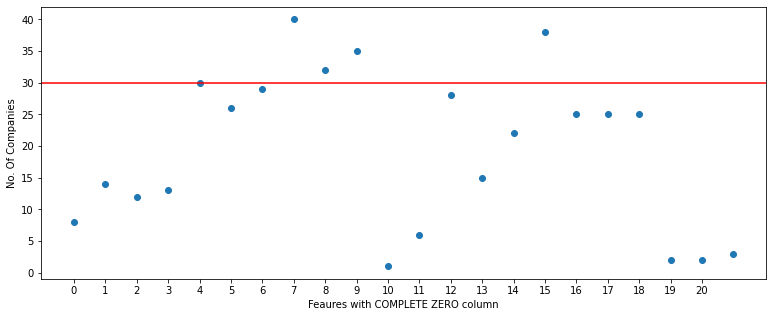

In [62]:
pltMissingCol(y_lst=company_dict.keys(),x_lst=colCount)

In [63]:
company_dict
#4,6,7,8,9,14,

{0: 'Other Operating Income',
 1: 'Consumption of Raw Materials',
 2: 'Purchase of Traded Goods',
 3: 'Increase/Decrease in Stocks',
 4: 'Power & Fuel',
 5: 'Excise Duty',
 6: 'Admin. And Selling Expenses',
 7: 'R & D Expenses',
 8: 'Provisions And Contingencies',
 9: 'Exp. Capitalised',
 10: 'Interest',
 11: 'Exceptional Items',
 12: 'Prior Year Adjustments',
 13: 'Extra Ordinary Items',
 14: 'Reserves Excluding Revaluation Reserves',
 15: 'Equity Dividend Rate (%)',
 16: 'No_ofShare_PledgedEncumbered',
 17: 'PerShare_PledgedEncumbered',
 18: 'PerShare_TotalShCapitalComp_PledgedEncumbered',
 19: 'No_ofShare_NonEncumbered',
 20: 'PerShare_TotalShofPromoter_NonEncumbered',
 21: 'PerShare_TotalShCapitalComp_NonEncumbered'}

It suggest that below columns are ZERO values in more than 30 companies


1.   Power & Fuel
2.   Admin. And Selling Expenses
3.   R & D Expenses
4.   Provisions And Contingencies
5.   Exp. Capitalised
6.   Equity Dividend Rate (%)



Not using this code anymore, lets not delete it 

In [64]:
# Excluding the above column having complete zero 
nonZeroValuFeature = {}
missingValue = {}

for col in company_lst:
  nonZeroValuFeature[col] = dataVal_com[dataVal_com['Sum']  != 0].groupby('CompanyName').get_group(col)['Feature'].tolist()
  
#count = 0
nonZeroValuFeature_df = pd.DataFrame(columns=['CompanyName','TotalRecord','Feature','MissingCount'])
index_count = 0

for key, value in nonZeroValuFeature.items():
  #print("\n {}".format(key))
  for col in value:
    count = data[data['CompanyName'] == key][col].isin([0]).sum().tolist()
    
    #print("Company Name:{}, Total Record:{}, Feature: {} , Count: {}".format(key,data_test[data_test['Company'] == key].shape[0],col,count))
    nonZeroValuFeature_df.loc[index_count] = [key,data[data['CompanyName'] == key].shape[0],col,count]
    
    index_count += 1
  

In [65]:
data.columns

Index(['Company_QuarterResult', 'Net Sales/Income from operations',
       'Other Operating Income', 'Total Income From Operations',
       'Consumption of Raw Materials', 'Purchase of Traded Goods',
       'Increase/Decrease in Stocks', 'Power & Fuel', 'Employees Cost',
       'Depreciation', 'Excise Duty', 'Admin. And Selling Expenses',
       'R & D Expenses', 'Provisions And Contingencies', 'Exp. Capitalised',
       'Other Expenses', 'P/L Before Other Inc. , Int., Excpt. Items & Tax',
       'Other Income', 'P/L Before Int., Excpt. Items & Tax', 'Interest',
       'P/L Before Exceptional Items & Tax', 'Exceptional Items',
       'P/L Before Tax', 'Tax', 'P/L After Tax from Ordinary Activities',
       'Prior Year Adjustments', 'Extra Ordinary Items',
       'Net Profit/(Loss) For the Period', 'Equity Share Capital',
       'Reserves Excluding Revaluation Reserves', 'Equity Dividend Rate (%)',
       'BasicEPS_BeforeExtraOrdinary', 'DilutedEPS_BeforeExtraOrdinary',
       'BasicEPS

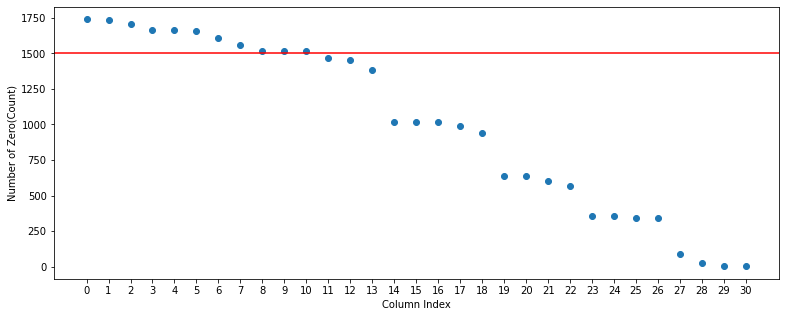

                                          colName  Count
0                                  R & D Expenses   1739
1                        Equity Dividend Rate (%)   1735
2                                     Excise Duty   1703
3                          Prior Year Adjustments   1665
4                                Exp. Capitalised   1661
5                    Provisions And Contingencies   1657
6                            Extra Ordinary Items   1608
7         Reserves Excluding Revaluation Reserves   1560
8   PerShare_TotalShCapitalComp_PledgedEncumbered   1518
9                      PerShare_PledgedEncumbered   1517
10                   No_ofShare_PledgedEncumbered   1517
11                    Admin. And Selling Expenses   1464
12                              Exceptional Items   1455
13                                   Power & Fuel   1385
14      PerShare_TotalShCapitalComp_NonEncumbered   1019
15                       No_ofShare_NonEncumbered   1017
16       PerShare_TotalShofProm

In [66]:
def drawMissingCol(display=False):
  missingCol_df = pd.DataFrame(columns=['colName','Count'])
  missingCol_df[['colName','Count']] = data.isin([0]).sum().reset_index()

  missingCol_df = missingCol_df.sort_values(by=['Count'],ascending=False).reset_index(drop=True)
  missingCol_df = missingCol_df[missingCol_df['Count'] > 0]

  rcParams['figure.figsize'] = 13, 5
  plt.xticks(np.arange(0,31,1))
  plt.scatter(missingCol_df.index,missingCol_df['Count'])
  plt.xlabel("Column Index")
  plt.ylabel("Number of Zero(Count)")
  plt.axhline(1500, c='r')
  plt.show()
  
  if(display):
    print(missingCol_df)
  
  
drawMissingCol(display=True)

In [67]:
data[['Company_QuarterResult','Tax']][data['CompanyName'] == 'IOC'].head()

,Company_QuarterResult,Tax
1355,IOC_032019,2535.12
1356,IOC_122018,627.80
1357,IOC_092018,1558.81
1358,IOC_062018,3511.04
1359,IOC_032018,2814.75


In [68]:
data[['Company_QuarterResult','Tax']][data['CompanyName'] == 'IOC']

,Company_QuarterResult,Tax
1355,IOC_032019,2535.12
1356,IOC_122018,627.80
1357,IOC_092018,1558.81
1358,IOC_062018,3511.04
1359,IOC_032018,2814.75
1360,IOC_122017,4368.97
1361,IOC_092017,1795.12
1362,IOC_062017,2239.32
1363,IOC_032017,-135.76
1364,IOC_122016,2195.82


Basic & Diluated EPS for Before & After ExtraOrdinary are highly corrleated with each other 

Lets keep only 1 of them out of 4

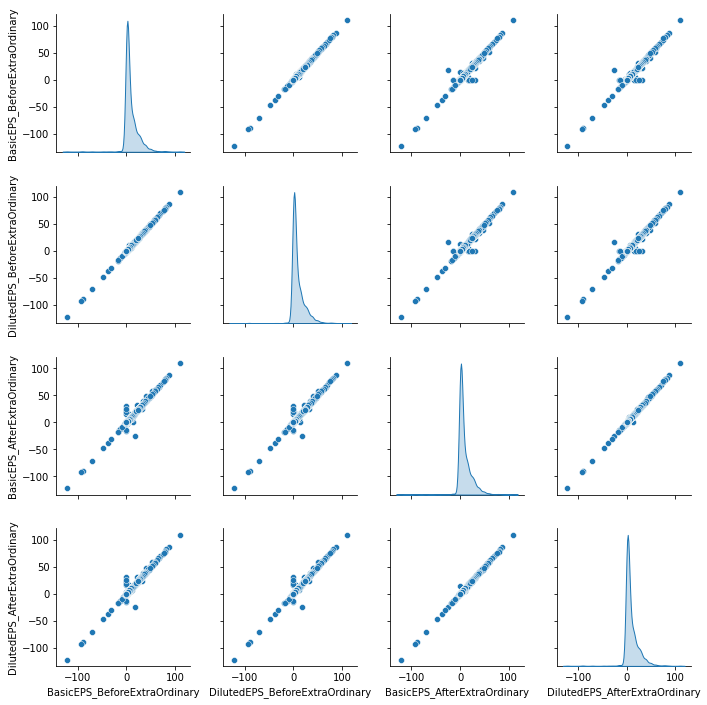

In [69]:
import seaborn as sns
sns.pairplot(data[['BasicEPS_BeforeExtraOrdinary','DilutedEPS_BeforeExtraOrdinary','BasicEPS_AfterExtraOrdinary','DilutedEPS_AfterExtraOrdinary']],diag_kind='kde')

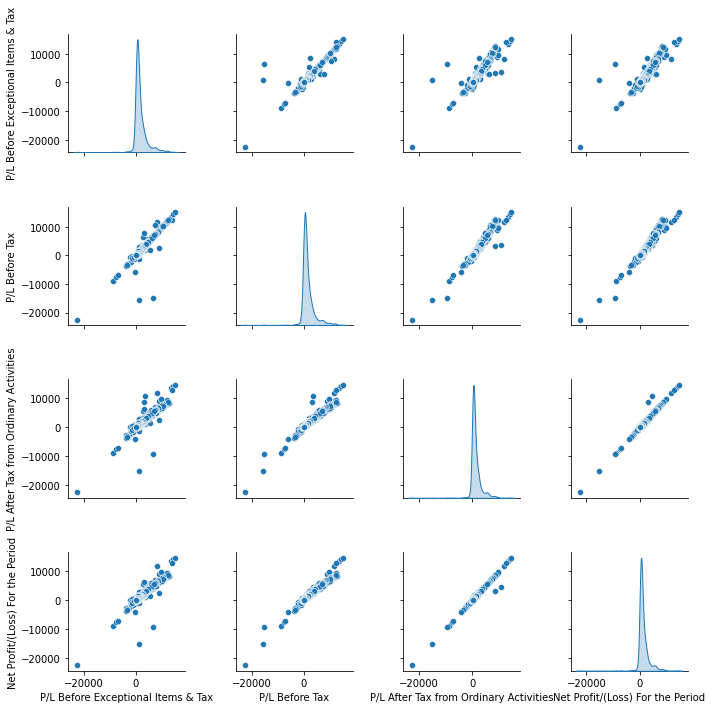

In [70]:
sns.pairplot(data[['P/L Before Exceptional Items & Tax','P/L Before Tax','P/L After Tax from Ordinary Activities','Net Profit/(Loss) For the Period']],diag_kind='kde')

#### Keep one of them only

* **P/L After Tax from Ordinary Activities** highly coorelated to **Net Profit/(Loss) For the Period** ( keep only one)
* **P/L Before Exceptional Items & Tax** highly coorelated to **P/L After Tax**

## Data - Wrangling ##

### Handling Missing data###



1.   Update 'Total Income From Operations' = 'Net Sales/Income from operations' + Other Operating Income

3.  Dropping following columns as showed in Data Analysis section + used in #1

*  Power & Fuel
*  Admin. And Selling Expenses
*  R & D Expenses
*  Provisions And Contingencies
*  Exp. Capitalised
*  Equity Dividend Rate (%)
*  Net Sales/Income from operations
*  Other Operating Income

From Section 2 & Pair Plot
*  Excise Duty
*  Prior Year Adjustments
*  Extra Ordinary Items
*  Reserves Excluding Revaluation Reserves
*  PerShare_TotalShCapitalComp_PledgedEncumbered
*  No_ofShare_PledgedEncumbered
*  PerShare_PledgedEncumbered
*  Exceptional Items
*  PerShare_TotalShCapitalComp_NonEncumbered ( Choosing no. of share )
*  PerShare_TotalShofPromoter_NonEncumbered  ( Choosing no. of share )
*  DilutedEPS_BeforeExtraOrdinary
*  BasicEPS_AfterExtraOrdinary
*  DilutedEPS_AfterExtraOrdinary

3.   Interpolate following Features

*   Emplyee Cost
*   Depreciation
*   Tax
*    No of Shares(Crores)

In [71]:
data['Total Income From Operations'] = data['Net Sales/Income from operations'] + data['Other Operating Income']

dropColumns = ['Power & Fuel','Admin. And Selling Expenses','R & D Expenses','Provisions And Contingencies',
               'Exp. Capitalised','Equity Dividend Rate (%)','Net Sales/Income from operations','Other Operating Income']

dropColumns2 = ['Excise Duty','Prior Year Adjustments','Extra Ordinary Items','Reserves Excluding Revaluation Reserves',
                'PerShare_TotalShCapitalComp_PledgedEncumbered','No_ofShare_PledgedEncumbered','PerShare_PledgedEncumbered',
                'Exceptional Items','PerShare_TotalShCapitalComp_NonEncumbered','PerShare_TotalShofPromoter_NonEncumbered',
                'DilutedEPS_BeforeExtraOrdinary','BasicEPS_AfterExtraOrdinary','DilutedEPS_AfterExtraOrdinary',
                'P/L Before Exceptional Items & Tax','P/L After Tax from Ordinary Activities']

data.drop(columns=dropColumns,inplace=True)
data.drop(columns=dropColumns2,inplace=True)

Post Dropping the column

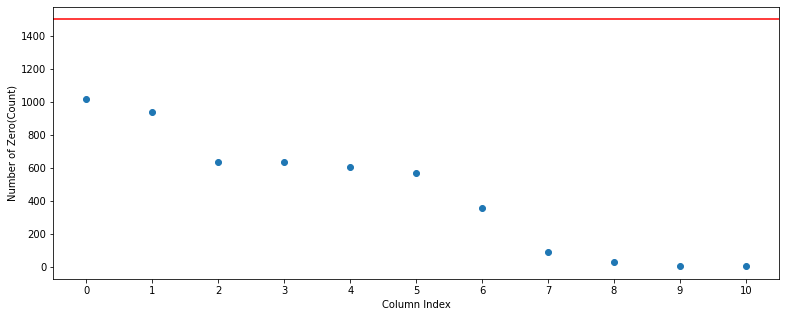

                         colName  Count
0       No_ofShare_NonEncumbered   1017
1       Purchase of Traded Goods    938
2              Share Holding (%)    636
3          No Of Shares (Crores)    636
4   Consumption of Raw Materials    604
5    Increase/Decrease in Stocks    570
6   BasicEPS_BeforeExtraOrdinary    354
7                       Interest     90
8                            Tax     28
9                   Other Income      6
10                 ChangePercent      1


In [72]:
drawMissingCol(display=True)

In [73]:
data[data['ChangePercent'] == 0]

## This is expected as for Bharti Airtel March2013 & June 2013 Closing Price is SAME

,Company_QuarterResult,Total Income From Operations,Consumption of Raw Materials,Purchase of Traded Goods,Increase/Decrease in Stocks,Employees Cost,Depreciation,Other Expenses,"P/L Before Other Inc. , Int., Excpt. Items & Tax",Other Income,"P/L Before Int., Excpt. Items & Tax",Interest,P/L Before Tax,Tax,Net Profit/(Loss) For the Period,Equity Share Capital,BasicEPS_BeforeExtraOrdinary,No Of Shares (Crores),Share Holding (%),No_ofShare_NonEncumbered,CompanyName,Quarter,Qtr,Year,ChangePercent
1033,Bharti Airtel_032013,11548.3,0.0,0.9,0.0,405.2,1756.8,6650.2,1732.0,91.8,1823.8,280.8,1543.0,458.6,1084.4,1898.8,2.86,119.43,31.45,260.32,Bharti Airtel,32013.0,3,2013,0.0


### Fill Missing Data ###

* Interpolate 
* Backword Fill

In [74]:
interpolFeatures = ['No_ofShare_NonEncumbered','Purchase of Traded Goods','No Of Shares (Crores)','Consumption of Raw Materials','Increase/Decrease in Stocks',
                   'BasicEPS_BeforeExtraOrdinary','Tax','Other Income',]

backwordfill = ['Interest','Share Holding (%)']

def fillMissingData(df,columns,Interpolate=True):  # Earlier True
  for comp in totalComp:
    for col in columns:
      if(Interpolate):
        temp = df[col][df['CompanyName'] == comp].replace(0,np.nan).interpolate()
      else:
        temp = df[col][df['CompanyName'] == comp].replace(0,np.nan).fillna(method='backfill')
      
      df.update(temp,overwrite=True)
      temp=""
      
  return df

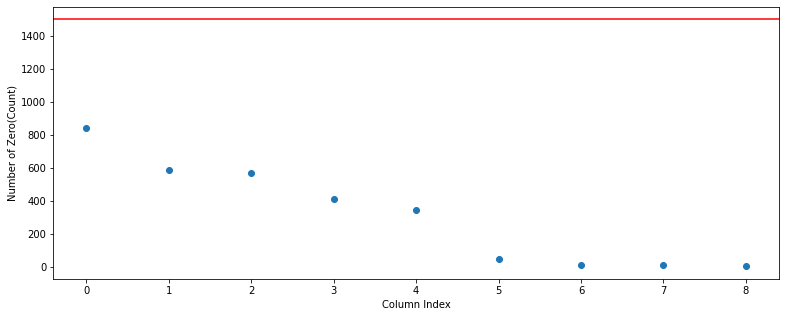

                        colName  Count
0      Purchase of Traded Goods    843
1  Consumption of Raw Materials    588
2   Increase/Decrease in Stocks    570
3      No_ofShare_NonEncumbered    413
4  BasicEPS_BeforeExtraOrdinary    342
5                      Interest     48
6             Share Holding (%)      9
7         No Of Shares (Crores)      9
8                 ChangePercent      1


In [75]:
data = fillMissingData(data.copy(),backwordfill,Interpolate=False)
data = fillMissingData(data.copy(),interpolFeatures,Interpolate=False)

# Final Feature with ZERO values
drawMissingCol(display=True)

In [76]:
data.shape

(1739, 25)

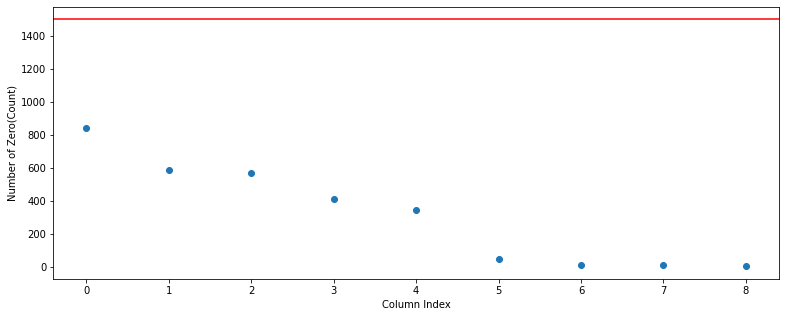

                        colName  Count
0      Purchase of Traded Goods    843
1  Consumption of Raw Materials    588
2   Increase/Decrease in Stocks    570
3      No_ofShare_NonEncumbered    413
4  BasicEPS_BeforeExtraOrdinary    342
5                      Interest     48
6             Share Holding (%)      9
7         No Of Shares (Crores)      9
8                 ChangePercent      1


In [77]:
drawMissingCol(display=True)

## Observation - Dropping above 5 columns where missing data is > 500

* No_ofShare_NonEncumbered   
* No Of Shares (Crores) 
* Consumption of Raw Materials 
* Increase/Decrease in Stocks 
* Purchase of Traded Goods

In [78]:
moreDrop = ['No_ofShare_NonEncumbered','No Of Shares (Crores)','Consumption of Raw Materials','Increase/Decrease in Stocks','Purchase of Traded Goods']
data.drop(columns = moreDrop,inplace=True)

In [79]:
data.shape

(1739, 20)

#### Global Variable

In [80]:
# Hold different year
year_lst = data['Year'].unique().tolist()
year_lst.sort()

totalComp = stockPrice['CompanyName'].unique().tolist()
quater_lst = [3,6,9,12]

## Yearly Data Pre Processing
* Keep only data from 2008 onwards
* Replace NAN with 0

In [81]:
dinu['Year'] = dinu['Year'].astype('int')
dinu = dinu[dinu['Year'] > 2007]

cashflow['Year'] = cashflow['Year'].astype('int')
cashflow = cashflow[cashflow['Year'] > 2007]

ratio['Year'] = ratio['Year'].astype('int')
ratio = ratio[ratio['Year'] > 2007]

dinu.replace(np.nan,0,inplace=True)
cashflow.replace(np.nan,0,inplace=True)
ratio.replace(np.nan,0,inplace=True)

## Data Analysis  & Pre-Processing on yearly Data Files ##
* balanceSheet
* cashflow
* ratio

### Balance Sheet

2008 -2019 -> 12 years * 40 Companies = 480 records

Below company(s) is having one year missing from source
* IBULHSGFIN
* INFRATEL
*  HINDUNILVR

In [82]:
dinu['CompanyName'].value_counts()

TCS                                      12
Bajaj Auto                               12
ITC                                      12
Reliance                                 12
TITAN                                    12
ULTRACEMCO                               12
MM                                       12
HEROMOTOCO                               12
INFY                                     12
ZEEL                                     12
Bajaj Finance                            12
HINDALCO                                 12
IOC                                      12
Britannia Industries Ltd                 12
UPL                                      12
JSWSteel                                 12
PowerGrid                                12
Bharat Petroleum Corporation Limited     12
TATASTEEL                                12
WIPRO                                    12
HCLTECH                                  12
Grasim                                   12
VEDL                            

### Missing Data in BalanceSHeet

In [83]:
def drawMissingColYearly(dt,display=True):
  
  missingCol_df = pd.DataFrame(columns=['colName','Count'])
  missingCol_df[['colName','Count']] = dt.isin([0]).sum().reset_index()

  missingCol_df = missingCol_df.sort_values(by=['Count'],ascending=False).reset_index(drop=True)
  missingCol_df = missingCol_df[missingCol_df['Count'] > 0]

  if(display):
    rcParams['figure.figsize'] = 13, 5
    plt.xticks(np.arange(0,31,1))
    plt.scatter(missingCol_df.index,missingCol_df['Count'])
    plt.xlabel("Column Index")
    plt.ylabel("Number of Zero(Count)")
    plt.axhline(70, c='r')
    plt.show()
    
    print(missingCol_df)
  
  else:
    return missingCol_df
  

In [84]:
dinu.shape

(477, 23)

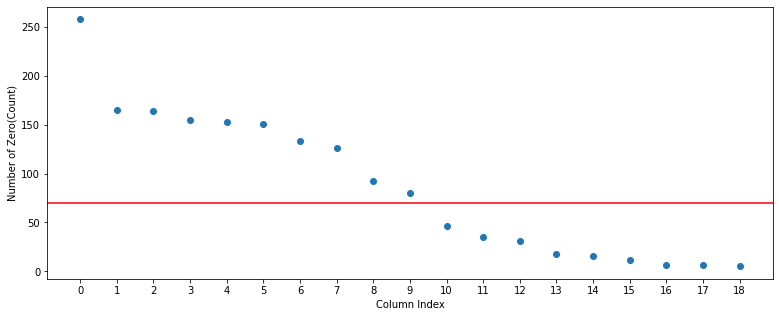

                           colName  Count
0        Deferred Tax Assets [Net]    258
1         Other Non-Current Assets    165
2              Current Investments    164
3            Short Term Borrowings    155
4             Long Term Provisions    153
5     Long Term Loans And Advances    151
6               OtherCurrentAssets    133
7   Deferred Tax Liabilities [Net]    126
8             Long Term Borrowings     92
9                      Inventories     80
10               Intangible Assets     46
11        Capital Work-In-Progress     35
12   Short Term Loans And Advances     31
13               Trade Receivables     18
14       Cash And Cash Equivalents     16
15         Non-Current Investments     12
16           Short Term Provisions      6
17                  Trade Payables      6
18                 Tangible Assets      5


In [85]:
drawMissingColYearly(dt = dinu)

### Missing data treatment
Delete Below Column in balance Sheet df

* Deferred Tax Assets [Net]
* Other Non-Current Assets
* Current Investments
* Long Term Provisions
* Long Term Loans And Advances
* Short Term Borrowings
* OtherCurrentAssets
* Deferred Tax Liabilities [Net]
* Long Term Borrowings
* Inventories 

*  Handling Missing data in Yearly files ( using both Interpolationa and backward fillng technique)


In [86]:
dropCol = ['Deferred Tax Assets [Net]','Other Non-Current Assets','Current Investments','Long Term Provisions','Long Term Loans And Advances',
           'Short Term Borrowings','OtherCurrentAssets','Deferred Tax Liabilities [Net]','Long Term Borrowings','Inventories']
dinu.drop(columns=dropCol,inplace=True)

In [87]:
# before missing data treatment

#dinu[dinu['Current Investments'] == 0]
dinu[['Year','Intangible Assets']][dinu['CompanyName'] =='INFY']

,Year,Intangible Assets
0,2019,25.75
1,2018,32.50
2,2017,0.00
3,2016,0.00
4,2015,0.00
0,2014,3.25
1,2013,7.00
2,2012,0.00
3,2011,0.00
4,2010,3.00


In [88]:
missCol = drawMissingColYearly(dt = dinu,display=False)
col_list = missCol['colName'].to_list()
dinu.reset_index(drop=True,inplace=True)
#col_list = ['Current Investments']

#dinu = fillMissingData(dinu.copy(),col_list,Interpolate=True) # Earlier True
dinu = fillMissingData(dinu.copy(),col_list,Interpolate=False)

In [89]:
dinu[['Year','Intangible Assets']][dinu['CompanyName'] =='INFY']

,Year,Intangible Assets
250,2019,25.75
251,2018,32.50
252,2017,3.25
253,2016,3.25
254,2015,3.25
255,2014,3.25
256,2013,7.00
257,2012,3.00
258,2011,3.00
259,2010,3.00


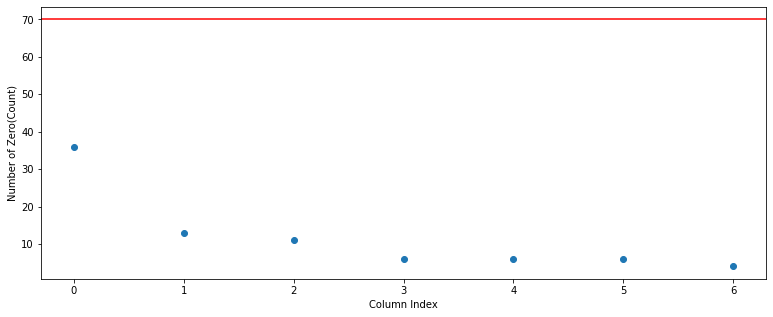

                         colName  Count
0              Intangible Assets     36
1       Capital Work-In-Progress     13
2              Trade Receivables     11
3        Non-Current Investments      6
4      Cash And Cash Equivalents      6
5  Short Term Loans And Advances      6
6                 Trade Payables      4


In [90]:
drawMissingColYearly(dt = dinu)

Above two columns are complte blank in Bajaj Finserv and Finance company 

### Missing Data in cashflow

In [91]:
cashflow['CompanyName'].value_counts()

TCS                                      12
ZEEL                                     12
ITC                                      12
Reliance                                 12
TITAN                                    12
ULTRACEMCO                               12
MM                                       12
HEROMOTOCO                               12
INFY                                     12
HINDALCO                                 12
Bajaj Finance                            12
IOC                                      12
Britannia Industries Ltd                 12
UPL                                      12
INFRATEL                                 12
JSWSteel                                 12
PowerGrid                                12
Bharat Petroleum Corporation Limited     12
TATASTEEL                                12
WIPRO                                    12
HCLTECH                                  12
Grasim                                   12
VEDL                            

In [92]:
cashflow.shape

(475, 7)

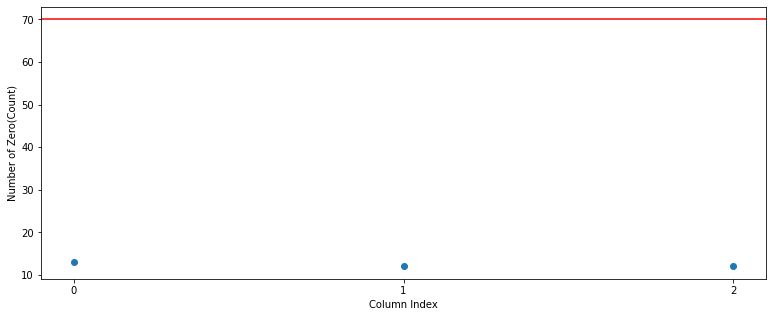

                                        colName  Count
0  Net Cash (used in)/from Financing Activities     13
1            Net Cash From Operating Activities     12
2  Net Cash (used in)/from Investing Activities     12


In [93]:
drawMissingColYearly(dt = cashflow)

In [94]:
cashflow[cashflow['Net Cash (used in)/from Financing Activities'] == 0].head()

,CompanyName,Net Cash From Operating Activities,Net Cash (used in)/from Investing Activities,Net Cash (used in)/from Financing Activities,Opening Cash & Cash Equivalents,Closing Cash & Cash Equivalents,Year
1,Bajaj Auto,0.000,0.0,0.0,279.82,190.2350,2018
2,Bajaj Auto,0.000,0.0,0.0,817.55,69.9550,2017
3,HEROMOTOCO,0.000,0.0,0.0,97.97,14.1175,2016
3,Bajaj Finance,0.000,0.0,0.0,227.76,331.8075,2016
7,INFRATEL,330.575,-327.2,0.0,4.30,4.4500,2012


In [95]:
missCol = drawMissingColYearly(dt = cashflow,display=False)
col_list = missCol['colName'].to_list()
cashflow.reset_index(drop=True,inplace=True)
#col_list = ['Current Investments']

#cashflow = fillMissingData(cashflow.copy(),col_list,Interpolate=True) # Earlier True
cashflow = fillMissingData(cashflow.copy(),col_list,Interpolate=False)

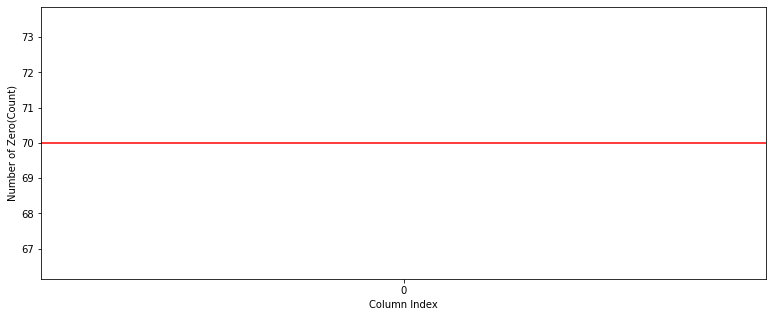

Empty DataFrame
Columns: [colName, Count]
Index: []


In [96]:
drawMissingColYearly(dt = cashflow)

 ### Missing Data in ratio


In [97]:
ratio.shape

(477, 11)

In [98]:
ratio['CompanyName'].value_counts()

TCS                                      12
Bajaj Auto                               12
ITC                                      12
Reliance                                 12
TITAN                                    12
ULTRACEMCO                               12
MM                                       12
HEROMOTOCO                               12
INFY                                     12
ZEEL                                     12
Bajaj Finance                            12
HINDALCO                                 12
IOC                                      12
Britannia Industries Ltd                 12
UPL                                      12
JSWSteel                                 12
PowerGrid                                12
Bharat Petroleum Corporation Limited     12
TATASTEEL                                12
WIPRO                                    12
HCLTECH                                  12
Grasim                                   12
VEDL                            

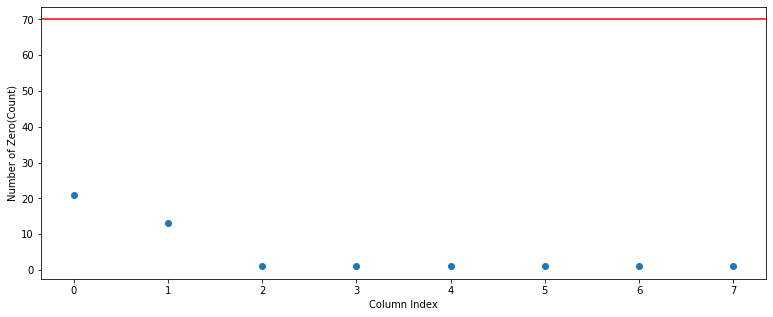

                               colName  Count
0  MarketCap/Net Operating Revenue (X)     21
1                Dividend / Share(Rs.)     13
2                      Basic EPS (Rs.)      1
3  Revenue from Operations/Share (Rs.)      1
4               Net Profit/Share (Rs.)      1
5      Return on Networth / Equity (%)      1
6       Return on Capital Employed (%)      1
7                 Return on Assets (%)      1


In [99]:
drawMissingColYearly(dt = ratio)

In [100]:
missCol = drawMissingColYearly(dt = ratio,display=False)
col_list = missCol['colName'].to_list()
ratio.reset_index(drop=True,inplace=True)
#col_list = ['Current Investments']

#ratio = fillMissingData(ratio.copy(),col_list,Interpolate=True)  # Earlier True
ratio = fillMissingData(ratio.copy(),col_list,Interpolate=False)

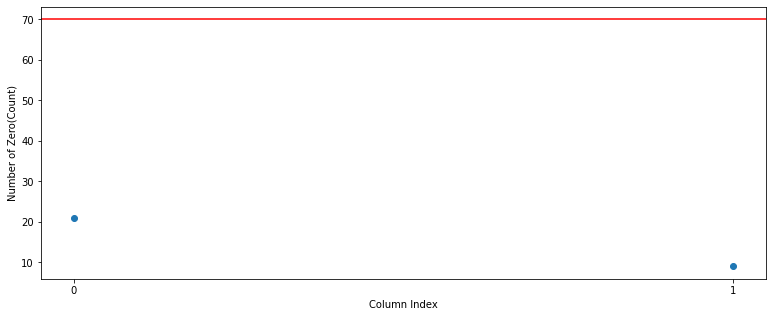

                               colName  Count
0  MarketCap/Net Operating Revenue (X)     21
1                Dividend / Share(Rs.)      9


In [101]:
drawMissingColYearly(dt = ratio)

## Data Merge  - Quaretly & Yearly Data Merge

* data + dinu + cashflow + ratio = finance_data

In [102]:
print(data.columns)
print(dinu.columns)
print(cashflow.columns)
print(ratio.columns)

Index(['Company_QuarterResult', 'Total Income From Operations',
       'Employees Cost', 'Depreciation', 'Other Expenses',
       'P/L Before Other Inc. , Int., Excpt. Items & Tax', 'Other Income',
       'P/L Before Int., Excpt. Items & Tax', 'Interest', 'P/L Before Tax',
       'Tax', 'Net Profit/(Loss) For the Period', 'Equity Share Capital',
       'BasicEPS_BeforeExtraOrdinary', 'Share Holding (%)', 'CompanyName',
       'Quarter', 'Qtr', 'Year', 'ChangePercent'],
      dtype='object')
Index(['CompanyName', 'Reserves and Surplus', 'Trade Payables',
       'Other Current Liabilities', 'Short Term Provisions', 'Tangible Assets',
       'Intangible Assets', 'Capital Work-In-Progress',
       'Non-Current Investments', 'Trade Receivables',
       'Cash And Cash Equivalents', 'Short Term Loans And Advances', 'Year'],
      dtype='object')
Index(['CompanyName', 'Net Cash From Operating Activities',
       'Net Cash (used in)/from Investing Activities',
       'Net Cash (used in)/from Fi

In [103]:
data[['CompanyName','Year','Qtr','Quarter']].head(1)

,CompanyName,Year,Qtr,Quarter
0,NTPC,2019,3,32019.0


In [104]:
dinu[['CompanyName','Year']].head(1)

,CompanyName,Year
0,Cipla,2019


In [105]:
cashflow[['CompanyName','Year']].head(1)

,CompanyName,Year
0,Cipla,2019


In [106]:
ratio[['CompanyName','Year']].head(1)

,CompanyName,Year
0,Cipla,2019


In [107]:
dinu.isin([np.nan]).sum()

CompanyName                      0
Reserves and Surplus             0
Trade Payables                   0
Other Current Liabilities        0
Short Term Provisions            0
Tangible Assets                  0
Intangible Assets                0
Capital Work-In-Progress         0
Non-Current Investments          0
Trade Receivables                0
Cash And Cash Equivalents        0
Short Term Loans And Advances    0
Year                             0
dtype: int64

In [108]:
def mergeData(data_df,dinu_df,cashflow_df,ratio_df):
  finance_data_df = pd.DataFrame()

  for comp in totalComp:
    for year in year_lst:
      for qtr in quater_lst:
        if( qtr in data_df['Qtr'][(data_df['Year'] == year) & (data_df['Qtr'] == qtr) & (data_df['CompanyName'] == comp)].to_list()):
        
          temp_fin_df = pd.concat([data_df[(data_df['CompanyName'] == comp) & (data_df['Year'] == year) & (data_df['Qtr'] == qtr)].reset_index(drop=True),
                         dinu_df[(dinu_df['CompanyName'] == comp) & (dinu_df['Year'] == year)].drop(columns=['CompanyName','Year']).reset_index(drop=True),# yearlyBalanceSheet
                         cashflow_df[(cashflow_df['CompanyName'] == comp) & (cashflow_df['Year'] == year)].drop(columns=['CompanyName','Year']).reset_index(drop=True),#cashflow
                         ratio_df[(ratio_df['CompanyName'] == comp) & (ratio_df['Year'] == year)].drop(columns=['CompanyName','Year']).reset_index(drop=True)],axis=1) #ratio
        
          finance_data_df = pd.concat([finance_data_df,temp_fin_df])
        else:
          print("{} not present for {} for {}".format(qtr,comp,year))
          
  return finance_data_df
        

In [109]:
## Merging:  Data (Quartley Statements) + Dinu ( Yearly Balanceh Sheet) + cashflow ( Yearly cash flow) + ratio ( Yearly Ration)
finance_data = mergeData(data,dinu,cashflow,ratio)

6 not present for NTPC for 2019
9 not present for NTPC for 2019
12 not present for NTPC for 2019
3 not present for Bajaj Finserv for 2008
6 not present for Bajaj Finserv for 2019
9 not present for Bajaj Finserv for 2019
12 not present for Bajaj Finserv for 2019
9 not present for TATASTEEL for 2015
12 not present for TATASTEEL for 2016
6 not present for TATASTEEL for 2019
9 not present for TATASTEEL for 2019
12 not present for TATASTEEL for 2019
6 not present for SUNPHARMA for 2014
12 not present for SUNPHARMA for 2016
6 not present for SUNPHARMA for 2019
9 not present for SUNPHARMA for 2019
12 not present for SUNPHARMA for 2019
6 not present for Bharat Petroleum Corporation Limited for 2019
9 not present for Bharat Petroleum Corporation Limited for 2019
12 not present for Bharat Petroleum Corporation Limited for 2019
6 not present for Cipla for 2019
9 not present for Cipla for 2019
12 not present for Cipla for 2019
6 not present for PowerGrid for 2019
9 not present for PowerGrid for 20

In [110]:
data.shape,dinu.shape,cashflow.shape,ratio.shape

((1739, 20), (477, 13), (475, 7), (477, 11))

In [111]:
finance_data.shape

(1739, 45)

In [112]:
finance_data = finance_data.reset_index(drop=True)

In [113]:
finance_data.isin([np.nan]).sum()

Company_QuarterResult                                0
Total Income From Operations                         0
Employees Cost                                       0
Depreciation                                         0
Other Expenses                                       0
P/L Before Other Inc. , Int., Excpt. Items & Tax     0
Other Income                                         0
P/L Before Int., Excpt. Items & Tax                  0
Interest                                             0
P/L Before Tax                                       0
Tax                                                  0
Net Profit/(Loss) For the Period                     0
Equity Share Capital                                 0
BasicEPS_BeforeExtraOrdinary                         0
Share Holding (%)                                    0
CompanyName                                          0
Quarter                                              0
Qtr                                                  0
Year      

In [114]:
indexDel = finance_data[finance_data.isna().any(axis=1)].index.to_list()
finance_data.drop(index = indexDel,inplace=True)



In [115]:
finance_data[finance_data.isna().any(axis=1)]

,Company_QuarterResult,Total Income From Operations,Employees Cost,Depreciation,Other Expenses,"P/L Before Other Inc. , Int., Excpt. Items & Tax",Other Income,"P/L Before Int., Excpt. Items & Tax",Interest,P/L Before Tax,Tax,Net Profit/(Loss) For the Period,Equity Share Capital,BasicEPS_BeforeExtraOrdinary,Share Holding (%),CompanyName,Quarter,Qtr,Year,ChangePercent,Reserves and Surplus,Trade Payables,Other Current Liabilities,Short Term Provisions,Tangible Assets,Intangible Assets,Capital Work-In-Progress,Non-Current Investments,Trade Receivables,Cash And Cash Equivalents,Short Term Loans And Advances,Net Cash From Operating Activities,Net Cash (used in)/from Investing Activities,Net Cash (used in)/from Financing Activities,Opening Cash & Cash Equivalents,Closing Cash & Cash Equivalents,Basic EPS (Rs.),Dividend / Share(Rs.),Revenue from Operations/Share (Rs.),Net Profit/Share (Rs.),Net Profit Margin (%),Return on Networth / Equity (%),Return on Capital Employed (%),Return on Assets (%),MarketCap/Net Operating Revenue (X)


In [116]:
finance_data.isin([np.nan]).sum()

Company_QuarterResult                               0
Total Income From Operations                        0
Employees Cost                                      0
Depreciation                                        0
Other Expenses                                      0
P/L Before Other Inc. , Int., Excpt. Items & Tax    0
Other Income                                        0
P/L Before Int., Excpt. Items & Tax                 0
Interest                                            0
P/L Before Tax                                      0
Tax                                                 0
Net Profit/(Loss) For the Period                    0
Equity Share Capital                                0
BasicEPS_BeforeExtraOrdinary                        0
Share Holding (%)                                   0
CompanyName                                         0
Quarter                                             0
Qtr                                                 0
Year                        

## Train-Test Data Split ##

Train Test Split: ( Total 8 set of each)
* Use ***Walk Forward Approach*** to split the data from 2008 - 2019 
* Setup Target variable (y)


> If Change Percent > 5 ---> 1 Else 0

* Train set: 2008 - 2011 ( 4 years)
* Test set: 2012 ( 1 year)





In [117]:
finance_data.drop(columns = ['Company_QuarterResult','CompanyName','Quarter'],inplace=True)

In [118]:
train_step = []
test_step = []
train_dict = {}
test_dict = {}

# SETTING UP TARGET VARIABLE
finance_data['Target'] = finance_data['ChangePercent'].apply(lambda x: 1 if x > 5 else 0)
finance_data.drop(columns=['ChangePercent'],inplace = True)
finance_data = finance_data.sort_values(by=['Year','Qtr'])

# Data list order
year_lst_order = finance_data['Year'].unique().tolist()
year_lst_order.sort()

for index,year in enumerate(year_lst_order):
  if(index + 4 < len(year_lst_order)):
    train_step = year_lst_order[index:4 + index]
    test_step = year_lst_order[index + 4]
    
    train_dict[index] = finance_data[finance_data['Year'].isin(train_step)]
    test_dict[index] = finance_data[finance_data['Year'].isin([test_step])]
    
  train_step.clear()
  test_step=''

Verify Train-Test Split and their Order

In [119]:
for index,year in enumerate(year_lst_order):
  if(index + 4 < len(year_lst_order)):
    print("train_step: {}".format(year_lst_order[index:4 + index]))
    print("test_step : {}".format(year_lst_order[index + 4]))

train_step: [2008, 2009, 2010, 2011]
test_step : 2012
train_step: [2009, 2010, 2011, 2012]
test_step : 2013
train_step: [2010, 2011, 2012, 2013]
test_step : 2014
train_step: [2011, 2012, 2013, 2014]
test_step : 2015
train_step: [2012, 2013, 2014, 2015]
test_step : 2016
train_step: [2013, 2014, 2015, 2016]
test_step : 2017
train_step: [2014, 2015, 2016, 2017]
test_step : 2018
train_step: [2015, 2016, 2017, 2018]
test_step : 2019


### Final Treatment

In [120]:
#sns.pairplot(finance_data[['Intangible Assets','Short Term Provisions']],diag_kind='kde')

In [121]:
#finance_data.drop(columns = ['Company_QuarterResult','CompanyName','Quarter','Qtr','Year'],inplace=True)

In [122]:
finance_data.shape

(1728, 42)

### PCA Analysis - Find Best k ###

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

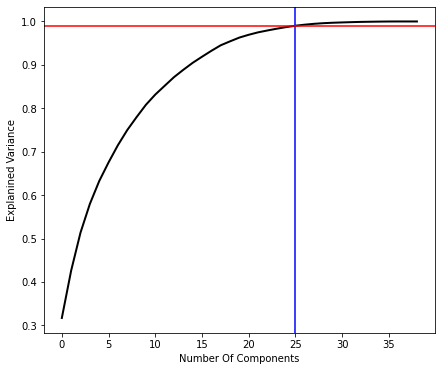

In [124]:
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(train_dict[0].drop(columns=['Qtr','Year','Target']))

#X_centered = X_scaled[0] - X_scaled[0].mean(axis=0)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(7,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k',lw=2)
plt.xlabel("Number Of Components")
plt.ylabel("Explanined Variance")
plt.axvline(25, c='b')

plt.axhline(.99, c='r')

plt.show()

In [125]:
def modelPrep(k,pcaCheck=False):
  scaler = StandardScaler()
  pipe_lst = []
  
  if(pcaCheck):
    pca = PCA(n_components=k)
    
    pipe_lst.append(('model_lr',Pipeline([('sclar',scaler),('pca',pca),('pipe_lr',LogisticRegression(random_state=42))])))
    pipe_lst.append(('model_dtc',Pipeline([('sclar',scaler),('pca',pca),('pipe_dtc',DecisionTreeClassifier(random_state=42))])))
    pipe_lst.append(('model_knnc',Pipeline([('sclar',scaler),('pca',pca),('pipe_knnc',KNeighborsClassifier())])))
    pipe_lst.append(('model_rfc',Pipeline([('sclar',scaler),('pca',pca),('pipe_rfc',RandomForestClassifier(random_state=42))])))
    pipe_lst.append(('model_abc',Pipeline([('sclar',scaler),('pca',pca),('pipe_abc',AdaBoostClassifier(random_state=42))])))
    pipe_lst.append(('model_gbc',Pipeline([('sclar',scaler),('pca',pca),('pipe_gbc',GradientBoostingClassifier(random_state=42))])))
    pipe_lst.append(('model_svc',Pipeline([('sclar',scaler),('pca',pca),('pipe_svc',SVC(random_state=42))])))

  else:
    pipe_lst.append(('model_lr',Pipeline([('sclar',scaler),('pipe_lr',LogisticRegression())])))
    pipe_lst.append(('model_dtc',Pipeline([('sclar',scaler),('pipe_dtc',DecisionTreeClassifier())])))
    pipe_lst.append(('model_knnc',Pipeline([('sclar',scaler),('pipe_knnc',KNeighborsClassifier())])))
    pipe_lst.append(('model_rfc',Pipeline([('sclar',scaler),('pipe_rfc',RandomForestClassifier())])))
    pipe_lst.append(('model_abc',Pipeline([('sclar',scaler),('pipe_abc',AdaBoostClassifier())])))
    pipe_lst.append(('model_gbc',Pipeline([('sclar',scaler),('pipe_gbc',GradientBoostingClassifier())])))
    pipe_lst.append(('model_svc',Pipeline([('sclar',scaler),('pipe_svc',SVC())])))

  ## GRID SEARCH PARAM
  grid_dict = {}
  float_space =  np.linspace(0.4, 0.9, 3, endpoint=True).tolist()
  max_features = ['sqrt']
  min_samples_leaf = [2,5,7,9]
  estimator = [50,70,100,150]
  criterian = ['gini','entropy']
  tree_depth = [2,3,5,6]
  learning_rate = [0.01,0.05,0.1,0.3]
  random_state = [42]


  grid_dict['model_lr'] = {'pipe_lr__penalty':['l1','l2'],'pipe_lr__C': np.logspace(0,4,10),'pipe_lr__random_state': random_state }

  grid_dict['model_dtc'] = {'pipe_dtc__criterion':criterian,'pipe_dtc__max_depth':tree_depth,
                            'pipe_dtc__min_samples_split': float_space,'pipe_dtc__min_samples_leaf':min_samples_leaf,
                            'pipe_dtc__max_features': max_features,'pipe_dtc__random_state': random_state }

  grid_dict['model_knnc'] = {'pipe_knnc__n_neighbors':[3,5,7,9,11],'pipe_knnc__weights':['uniform','distance'],
                             'pipe_knnc__algorithm':['ball_tree','kd_tree','brute'],'pipe_knnc__metric':['euclidean','manhattan'],
                             'pipe_knnc__n_jobs':[-1] }

  grid_dict['model_rfc'] = {'pipe_rfc__n_estimators':estimator,'pipe_rfc__criterion':criterian,'pipe_rfc__max_depth':tree_depth + [None,1],
                            'pipe_rfc__min_samples_leaf':min_samples_leaf,
                            'pipe_rfc__max_features': max_features,'pipe_rfc__random_state': random_state }

  grid_dict['model_abc'] = {'pipe_abc__n_estimators':estimator,'pipe_abc__learning_rate':learning_rate,'pipe_abc__random_state': random_state}

  grid_dict['model_gbc'] = {'pipe_gbc__n_estimators':estimator,'pipe_gbc__learning_rate':learning_rate,                          
                            'pipe_gbc__min_samples_leaf':min_samples_leaf,
                            'pipe_gbc__max_depth':tree_depth + [None,1],'pipe_gbc__max_features':max_features,'pipe_gbc__random_state': random_state}

  grid_dict['model_svc'] = {'pipe_svc__gamma':[1,0.1,0.001,0.0001],'pipe_svc__C':[1,10,100,1000],
                            'pipe_svc__kernel':['rbf','linear','sigmoid'],'pipe_svc__random_state': random_state}
  
  return pipe_lst,grid_dict


In [126]:
def models_prediction(models,grid,steps=[0],gridSearch=False,score='f1_macro'):
  index = 0
  param = {}
  model_results = pd.DataFrame(columns=['ModelName','StepNo','F1_Score','Recall_Score','GridSearch'])
   
  for step in steps:
    X_train = train_dict[step].drop(columns=['Target','Qtr','Year'])
    y_train = train_dict[step]['Target']

    X_test = test_dict[step].drop(columns=['Target','Qtr','Year'])
    y_test = test_dict[step]['Target']
  
    for name,model in models:
      #print("Running for {} on {}".format(step,name))
      
      if(gridSearch):
        gs = GridSearchCV(estimator=model,param_grid=grid[name],scoring=score)
        gs.fit(X_train,y_train)
        y_predict = gs.predict(X_test)
        param = gs.best_params_
      else:
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        param = 0
        
      f1 = metrics.f1_score(y_test,y_predict)
      recall = metrics.recall_score(y_test,y_predict)
  
      model_results.loc[index] = [name,step,f1,recall,param]
      index += 1
  
  return model_results

In [127]:
pipe_lst, grid_dict = modelPrep(k=30,pcaCheck=False)
default_noPCA = models_prediction(models = pipe_lst,grid = grid_dict,steps=[0,1,2,3,4,5,6,7],score='f1')

In [128]:
pipe_lst, grid_dict = modelPrep(k=30,pcaCheck=True)
default_PCA = models_prediction(models = pipe_lst,grid = grid_dict,steps=[0,1,2,3,4,5,6,7],score='f1')

In [129]:
def modelPerformance(title,data):
  
  plt.figure(figsize=(10,6))
  plt.grid()
  
  models = data['ModelName'][data['StepNo'] == 0]
    
  steps = range(0,8)
  for step in steps:
    plt.plot(models,data['F1_Score'][data['StepNo'] == step].tolist())

  plt.yticks(np.arange(0,1,.1))
  plt.xlabel("Models")
  plt.ylabel("Accuracy : F1_Score")
  plt.legend(steps)
  plt.title(title)
  plt.show()

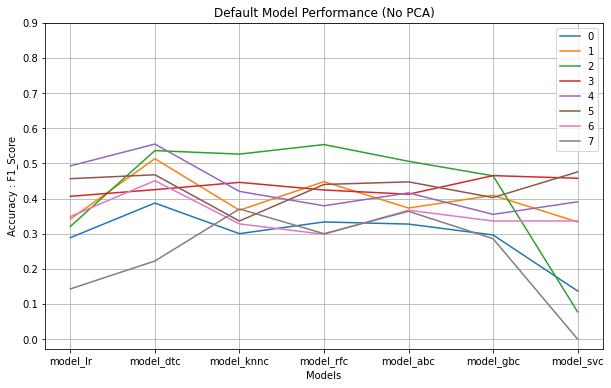

In [130]:
modelPerformance(title = "Default Model Performance (No PCA)",data = default_noPCA)

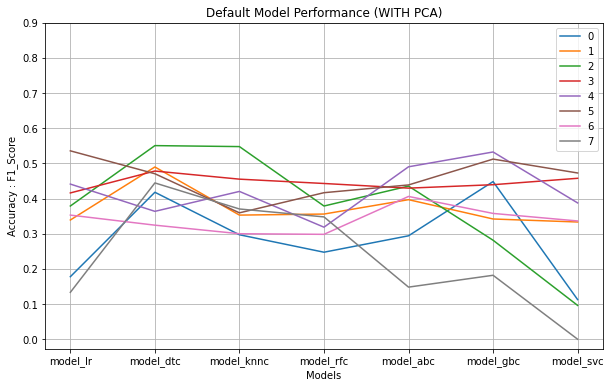

In [131]:
modelPerformance(title = "Default Model Performance (WITH PCA)",data = default_PCA)

### With PCA we have more consistent results, So we will build our model using PCA

In [132]:
pipe_lst, grid_dict = modelPrep(k=30,pcaCheck=True)
#results = models_prediction(models = pipe_lst,grid = grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True)

#modelPerformance(title = "Model Performance, With HyperParameter Tunning",data = results)

## Final Model To apply on the data set
* Random Forest Classifier
* Ada Boost Classifier

#### Find Best k (PCA's n_components) by applying RFC on all datasets

In [133]:
def findkPCA(model,steps=[0],k=[27]):
  
  results = pd.DataFrame(columns=['step','k','f1_score'])
  index = 0
  
  for step in steps:
    X_train = train_dict[step].drop(columns=['Target','Qtr','Year'])
    y_train = train_dict[step]['Target']
    
    X_test = test_dict[step].drop(columns=['Target','Qtr','Year'])
    y_test = test_dict[step]['Target']
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    for k_value in k:
      pca = PCA(n_components=k_value)
      X_train_pca = pca.fit_transform(X_train)
      X_test_pca = pca.transform(X_test)
      
      model.fit(X_train_pca,y_train)
      y_predict = model.predict(X_test_pca)
      #print(step,k_value,metrics.f1_score(y_test,y_predict))
      
      results.loc[index] = [step,k_value,metrics.f1_score(y_test,y_predict)]
      index += 1
 
  sns.barplot(x='k',y='f1_score',hue='step',data=results)
  plt.ylabel("F1_Score")
  plt.xlabel("K values")
  plt.axhline(.5,c='r')
  plt.axhline(.4,c='b')
  plt.legend(loc='bottom right')

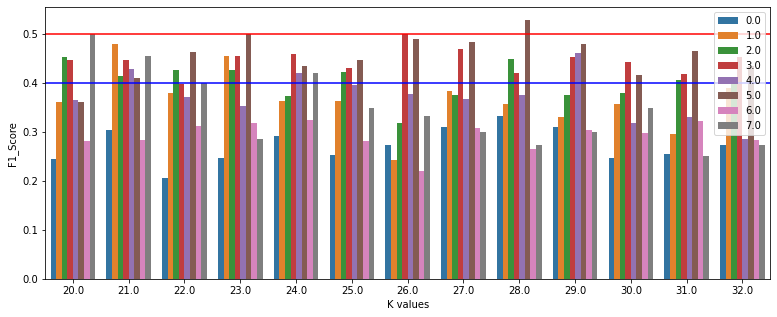

In [134]:
rfc_model = RandomForestClassifier(random_state=42)
findkPCA(model=rfc_model,steps=[0,1,2,3,4,5,6,7],k=[20,21,22,23,24,25,26,27,28,29,30,31,32])


#### We have decided to choose k as 30
#### Build Final RFC with below details
*pca k = 30

In [135]:
def resultComparision(data,baseResults = default_PCA):
  
  modelname = data['ModelName'].unique().tolist()
  title = "{} with Grid Search best Param".format(modelname[0])

  defaultResults = baseResults['F1_Score'][baseResults['ModelName'] == modelname[0]].tolist()

  plt.figure(figsize=(8,5))
  plt.grid()

  models = data['ModelName'][data['StepNo'] == 0]
  print("{} with Default Param Mean: {}".format(modelname[0],np.mean(defaultResults)))
  print("{} with HyperTune Param Mean: {}\n".format(modelname[0],np.mean(data['F1_Score'].tolist())))

  steps = np.arange(0,8)
  plt.plot(steps,data['F1_Score'].tolist(),label="HyperTune Param")
  plt.plot(defaultResults,label="Default param")
  plt.yticks(np.arange(0,1,.1))
  plt.legend(loc='upper right')
  plt.xlabel("Model at Different Steps")
  plt.ylabel("F1 Score")
  plt.title(title)
  plt.show()  
  
def train_test_data(train_data,test_data,k=30):
  X_train = train_data.drop(columns=['Target','Qtr','Year'])
  y_train = train_data['Target']
    
  X_test = test_data.drop(columns=['Target','Qtr','Year'])
  y_test = test_data['Target']
    
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  
  pca = PCA(n_components=k)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)
  
  return X_train_pca,X_test_pca,y_train,y_test


def train_test_accuracy(train_data,test_data,gridSearchResults_df,estimator,showText=False):
  
  grid_param = {}
  train_acc = []
  test_acc = []
      
  for param,step in gridSearchResults_df[['GridSearch','StepNo']].itertuples(index=False):
    X_train,X_test,y_train,y_test = train_test_data(train_data[step],test_data[step])
    
    for key,value in param.items():
      id = key.split('__')[1]
      grid_param[id] = value
           
    model = estimator(**grid_param)   
    model.fit(X_train,y_train)

    y_train_predict = model.predict(X_train)
    y_predict = model.predict(X_test)
    
    train_acc.append(metrics.f1_score(y_train,y_train_predict))
    test_acc.append(metrics.f1_score(y_test,y_predict))
    if(showText):
      print("STEP: {} Train accuracy: {}, Test accuracy: {}".format(step,metrics.f1_score(y_train,y_train_predict),metrics.f1_score(y_test,y_predict)))
    
  steps = np.arange(len(train_data))
  plt.figure(figsize=(8,5))
  plt.plot(steps,train_acc,label="Training Accuracy")
  plt.plot(test_acc,label="Test Accuracy")
  plt.yticks(np.arange(0,1,.1))
  plt.legend(loc='bottom right')
  plt.xlabel("Steps")
  plt.ylabel("F1 Score")
  plt.title("Training vs Test Accuracy")
  plt.grid()
  plt.show()  

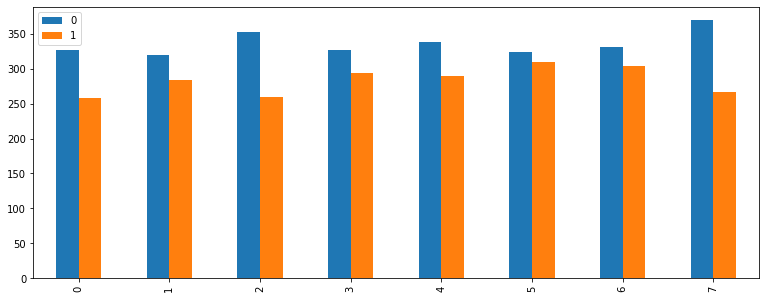

In [136]:
def classInfo(train_data):
  classCount = {}
  
  for i in np.arange(len(train_data)):
    classCount[i] = train_data[i]['Target'].value_counts().tolist()
    
  df = pd.DataFrame(data = classCount).T
  df.plot.bar()
  
classInfo(train_data = train_dict)

In [137]:
rt = {}
y_train = train_dict[0]['Target']
rt[0] = y_train.value_counts().tolist()

model_rfc with Default Param Mean: 0.35079029298774494
model_rfc with HyperTune Param Mean: 0.3605955950376144



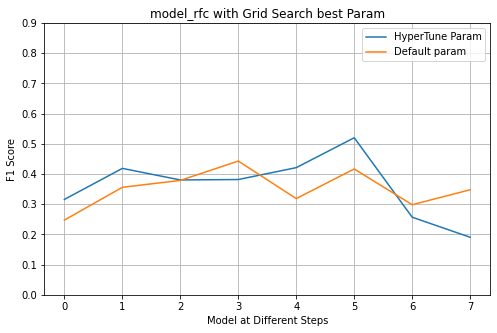

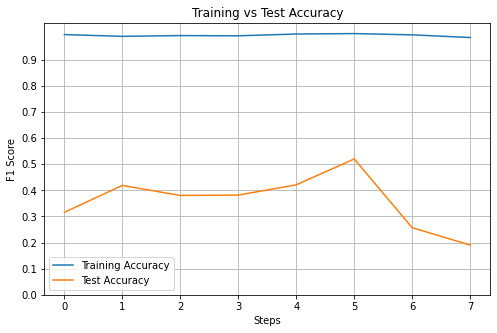

In [138]:
## Random Forest Best Param , Overal F1 Score - 44.71

final_pipe_lst = []
final_grid_dict = {}

scaler = StandardScaler()
pca = PCA(n_components=30)
estimator = RandomForestClassifier() 

final_pipe_lst.append(('model_rfc',Pipeline([('sclar',scaler),('pca',pca),('pipe_rfc',estimator)])))

estimator = [10,15,20,25,30,35]
criterian = ['gini','entropy']
max_features = ['log2','sqrt']
random_state = [42]

final_grid_dict['model_rfc'] = {'pipe_rfc__n_estimators':estimator,'pipe_rfc__random_state':random_state,
                               'pipe_rfc__max_features': max_features}

final_model_results = models_prediction(models = final_pipe_lst,grid = final_grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True,score = "f1")                              
resultComparision(data = final_model_results)
train_test_accuracy(train_data=train_dict,test_data=test_dict,gridSearchResults_df=final_model_results,estimator=RandomForestClassifier)


In [ ]:
## ADA Boost Classifier Best Param , Overal F1 Score - 49.21

final_pipe_lst = []
final_grid_dict = {}

scaler = StandardScaler()
pca = PCA(n_components=25)

final_pipe_lst.append(('model_abc',Pipeline([('sclar',scaler),('pca',pca),('pipe_abc',AdaBoostClassifier())])))

estimator = [10,15,20,25,30,35,40]
learning_rate = [0.01,1,.5]
random_state = [42]

final_grid_dict['model_abc'] = {'pipe_abc__n_estimators':estimator,'pipe_abc__learning_rate': learning_rate,
                                'pipe_abc__random_state':random_state}

final_model_results = models_prediction(models = final_pipe_lst,grid = final_grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True,score = "f1")
resultComparision(data = final_model_results)
train_test_accuracy(train_data=train_dict,test_data=test_dict,gridSearchResults_df=final_model_results,estimator=AdaBoostClassifier)

In [ ]:
## Gradient Boosting best Param , Overal F1 Score - 46.78
final_pipe_lst = []
final_grid_dict = {}

scaler = StandardScaler()
pca = PCA(n_components=30)

final_pipe_lst.append(('model_gbc',Pipeline([('sclar',scaler),('pca',pca),('pipe_gbc',GradientBoostingClassifier())])))

estimator = [200,250,300,400,500]
learning_rate = [.1]
random_state = [42]
#min_samples_split = [2,4,6,8,10,20,40,60,100]

final_grid_dict['model_gbc'] = {'pipe_gbc__n_estimators':estimator,'pipe_gbc__learning_rate':learning_rate,                          
                               'pipe_gbc__random_state': random_state } #'pipe_gbc__min_samples_split':min_samples_split}

final_model_results = models_prediction(models = final_pipe_lst,grid = final_grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True,score = "f1")
resultComparision(data = final_model_results)
train_test_accuracy(train_data=train_dict,test_data=test_dict,gridSearchResults_df=final_model_results,estimator=GradientBoostingClassifier)

In [ ]:
pd.set_option('display.max_colwidth', -1)

model_svc with Default Param Mean: 0.2917000840137613
model_svc with HyperTune Param Mean: 0.3043462483992036



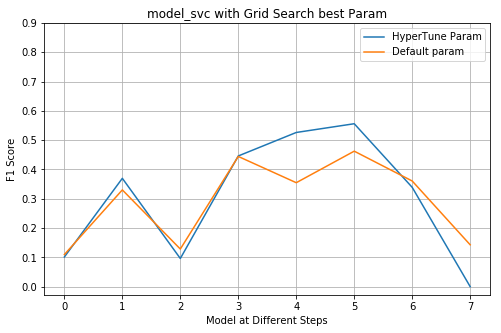

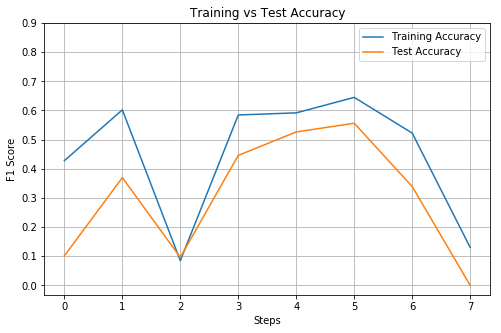

In [ ]:
## Support Vector Classifier Best Param , Overal F1 Score - 

final_pipe_lst = []
final_grid_dict = {}

scaler = StandardScaler()
pca = PCA(n_components=30)

final_pipe_lst.append(('model_svc',Pipeline([('sclar',scaler),('pca',pca),('pipe_svc',SVC())])))

C = [100]#,200,300,500,1000]
kernel = ['linear']
random_state = [42]

final_grid_dict['model_svc'] = {'pipe_svc__C':C,'pipe_svc__random_state':random_state,'pipe_svc__kernel':kernel}

final_model_results = models_prediction(models = final_pipe_lst,grid = final_grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True,score = "f1")
resultComparision(data = final_model_results)
train_test_accuracy(train_data=train_dict,test_data=test_dict,gridSearchResults_df=final_model_results,estimator=SVC)

## TESTING the Poor gridsearch results

In [ ]:
X_train = train_dict[3].drop(columns = ['Target','Qtr','Year'])
y_train = train_dict[3]['Target']

X_test = test_dict[3].drop(columns = ['Target','Qtr','Year'])
y_test = test_dict[3]['Target']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#model = RandomForestClassifier(random_state = 42)
model = RandomForestClassifier(criterion='gini',max_depth=1,max_features='auto',min_samples_leaf=1,
                              min_samples_split=2,n_estimators=10,random_state=42)

model.fit(X_train_pca,y_train)
y_predict = model.predict(X_test_pca)

print(metrics.f1_score(y_test,y_predict))

#float_space =  np.linspace(0.4, 0.9, 3, endpoint=True).tolist()

#estimator = [10,15,20,25,30] #,35]
#criterian = ['gini','entropy']
#max_depth = [1,None]
#min_sample_split = [2,3,4,5,6]
#min_samples_leaf = [1,2,3,4,5]
#max_features = ['auto']
#random_state = [42]

#learning_rate = [0.01,0.05,0.1,0.3]

#final_grid_dict['model_rfc'] = {'pipe_rfc__n_estimators':estimator,'pipe_rfc__criterion':criterian,'pipe_rfc__max_depth':max_depth,
#                                'pipe_rfc__min_samples_leaf':min_samples_leaf,'pipe_rfc__max_features': max_features,
#                                'pipe_rfc__min_samples_split':min_sample_split,'pipe_rfc__random_state':random_state }#


#final_grid_dict['model_abc'] = {'pipe_abc__n_estimators':estimator,'pipe_abc__learning_rate':learning_rate}



0.2524271844660194


In [ ]:
{'pipe_rfc__criterion': 'gini', 'pipe_rfc__max_depth': 1, 'pipe_rfc__max_features': 'auto', 'pipe_rfc__min_samples_leaf': 4, 
 'pipe_rfc__min_samples_split': 2, 'pipe_rfc__n_estimators': 10, 'pipe_rfc__random_state': 42}

## Model Run with Best Param Settings

In [ ]:
abc_model = AdaBoostClassifier(random_state=42)
findkPCA(model=abc_model,steps=[0,1,2,3,4,5,6,7],k=[20,21,22,23,24,25,26,27,28,29,30])

In [ ]:
gbc_model = GradientBoostingClassifier(random_state=42)
findkPCA(model=gbc_model,steps=[0,1,2,3,4,5,6,7],k=[20,21,22,23,24,25,26,27,28,29,30])

In [ ]:
{'pipe_rfc__criterion': 'gini', 'pipe_rfc__max_depth': None, 'pipe_rfc__max_features': 'auto',
 'pipe_rfc__min_samples_leaf': 5, 'pipe_rfc__min_samples_split': 2, 'pipe_rfc__n_estimators': 20, 'pipe_rfc__random_state': 42}

In [ ]:
rfcTEST = models_predictionTEST(models = final_pipe_lst,grid = final_grid_dict,steps=[0,1,2,3,4,5,6,7],gridSearch=True)

## Model To try
* LGB Classifier
* CatBoost


AUC: 0.895


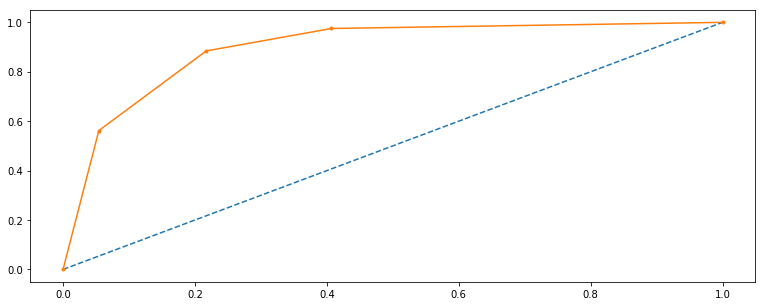

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)

probs = model.predict_proba(testX)
probs = probs[:, 1]

auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(testy, probs)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

In [ ]:
fpr#, tpr, thresholds

array([0.        , 0.05426357, 0.21705426, 0.40697674, 1.        ])

In [ ]:
testy[0:10]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

## Data Analysis

In [ ]:
## reset the index of train Data
for i in range(len(train_dict)):
  train_dict[i].reset_index(drop=True,inplace=True)

In [ ]:
train_dict[0].drop(columns=['Target','Qtr','Year']).columns

Index(['Total Income From Operations', 'Employees Cost', 'Depreciation',
       'Other Expenses', 'P/L Before Other Inc. , Int., Excpt. Items & Tax',
       'Other Income', 'P/L Before Int., Excpt. Items & Tax', 'Interest',
       'P/L Before Tax', 'Tax', 'Net Profit/(Loss) For the Period',
       'Equity Share Capital', 'BasicEPS_BeforeExtraOrdinary',
       'Share Holding (%)', 'Capital Work-In-Progress',
       'Cash And Cash Equivalents', 'Equity Share Capital',
       'Intangible Assets', 'Non-Current Investments',
       'Other Current Liabilities', 'Reserves and Surplus',
       'Short Term Loans And Advances', 'Short Term Provisions',
       'Tangible Assets', 'Trade Payables', 'Trade Receivables',
       'Net Cash From Operating Activities',
       'Net Cash (used in)/from Investing Activities',
       'Net Cash (used in)/from Financing Activities',
       'Opening Cash & Cash Equivalents', 'Closing Cash & Cash Equivalents',
       'Basic EPS (Rs.)', 'Dividend / Share(Rs.)',
 

In [ ]:
quartelyFeatures = data.drop(columns = ['Company_QuarterResult','CompanyName','Quarter','Qtr','Year','ChangePercent']).columns.tolist()
yearlyFeatures = set(train_dict[0].drop(columns=['Qtr','Year','Target']).columns) - set(quartelyFeatures)

In [ ]:
quartelyFeatures
#quartelyFeatures.append('Target')

In [ ]:
quartelyFeatures

['Total Income From Operations',
 'Employees Cost',
 'Depreciation',
 'Other Expenses',
 'P/L Before Other Inc. , Int., Excpt. Items & Tax',
 'Other Income',
 'P/L Before Int., Excpt. Items & Tax',
 'Interest',
 'P/L Before Tax',
 'Tax',
 'Net Profit/(Loss) For the Period',
 'Equity Share Capital',
 'BasicEPS_BeforeExtraOrdinary',
 'Share Holding (%)']

In [ ]:
#rcParams['figure.figsize'] = 6, 4
#train_dict[0] + train_dict[1]

In [ ]:
## Bi-variate analysis of Quaretely Feature vs Target Column

def bivariate_eda(train_data,cols,all=False):
  if(all):
    train_data = pd.concat([train_data[0],train_data[1],train_data[2],train_data[3],train_data[4],train_data[5],train_data[6],train_data[7]])
  print(train_data.shape)
  fig,axes = plt.subplots(nrows = len(cols),ncols = 2,figsize=(12,60),squeeze=False)
  for i,col in enumerate(cols):
    sns.boxplot(y=col,x='Target',data=train_data,ax = axes[i][0])
    kde = sns.kdeplot(train_data[col],ax = axes[i][1])
    kde.set_xlabel(col)
    kde.set_ylabel('Count')

### Bi-variate Analysis of Quartely data with Target column

(584, 42)


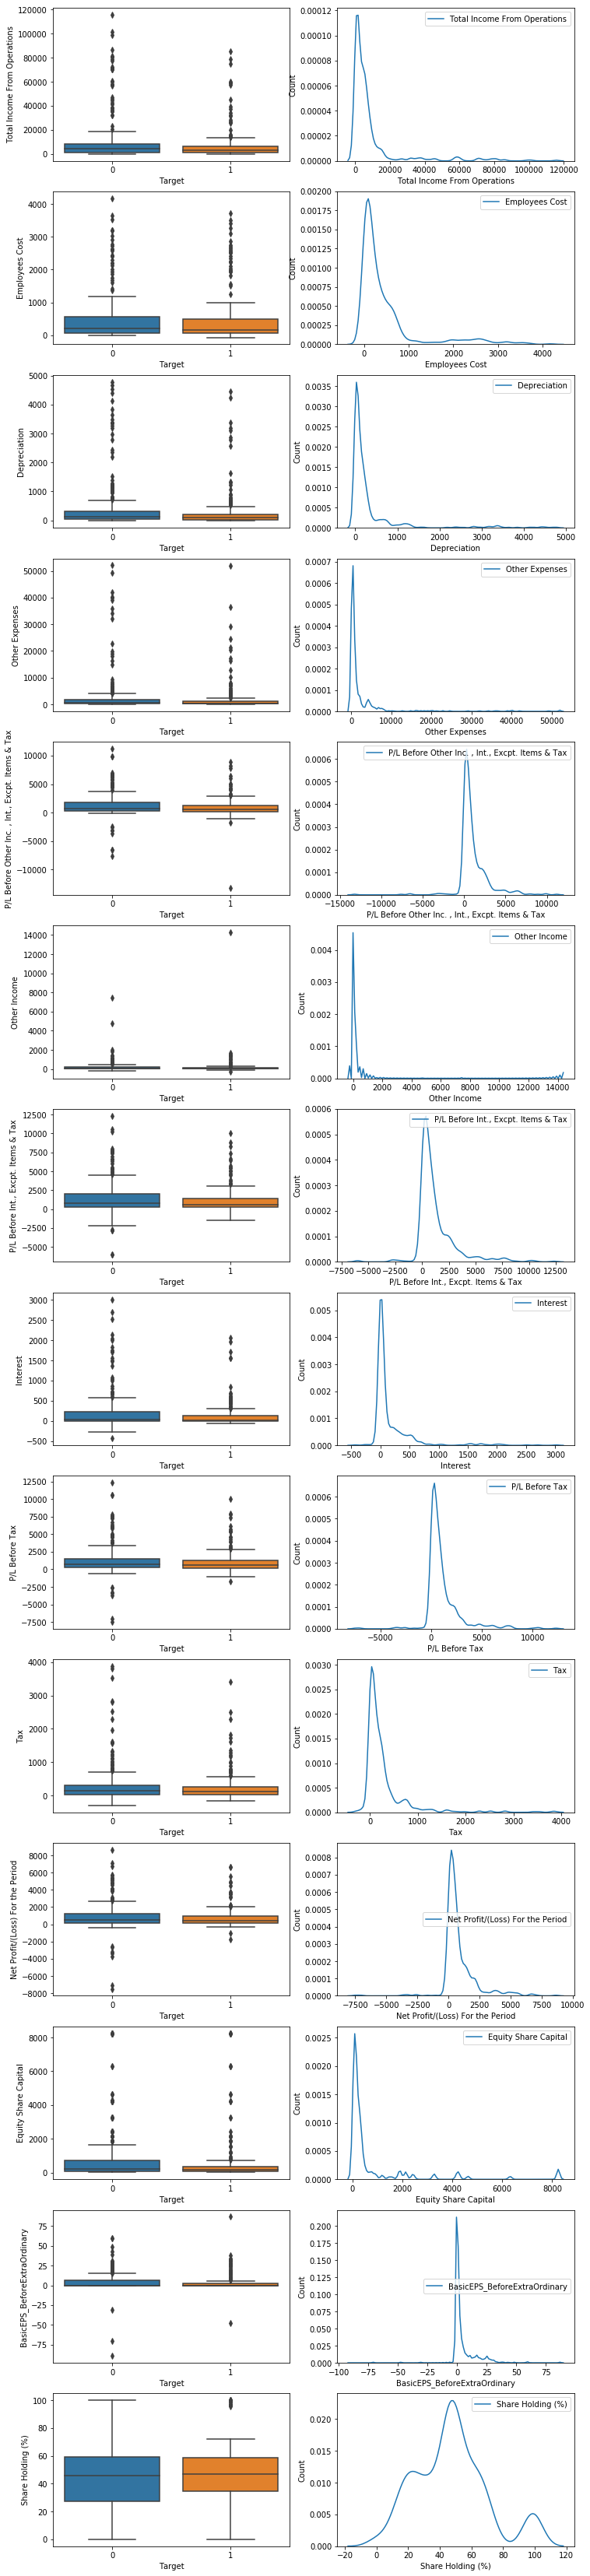

In [ ]:
## for STEP 0
bivariate_eda(train_data=train_dict[0],cols=quartelyFeatures)

(4951, 42)


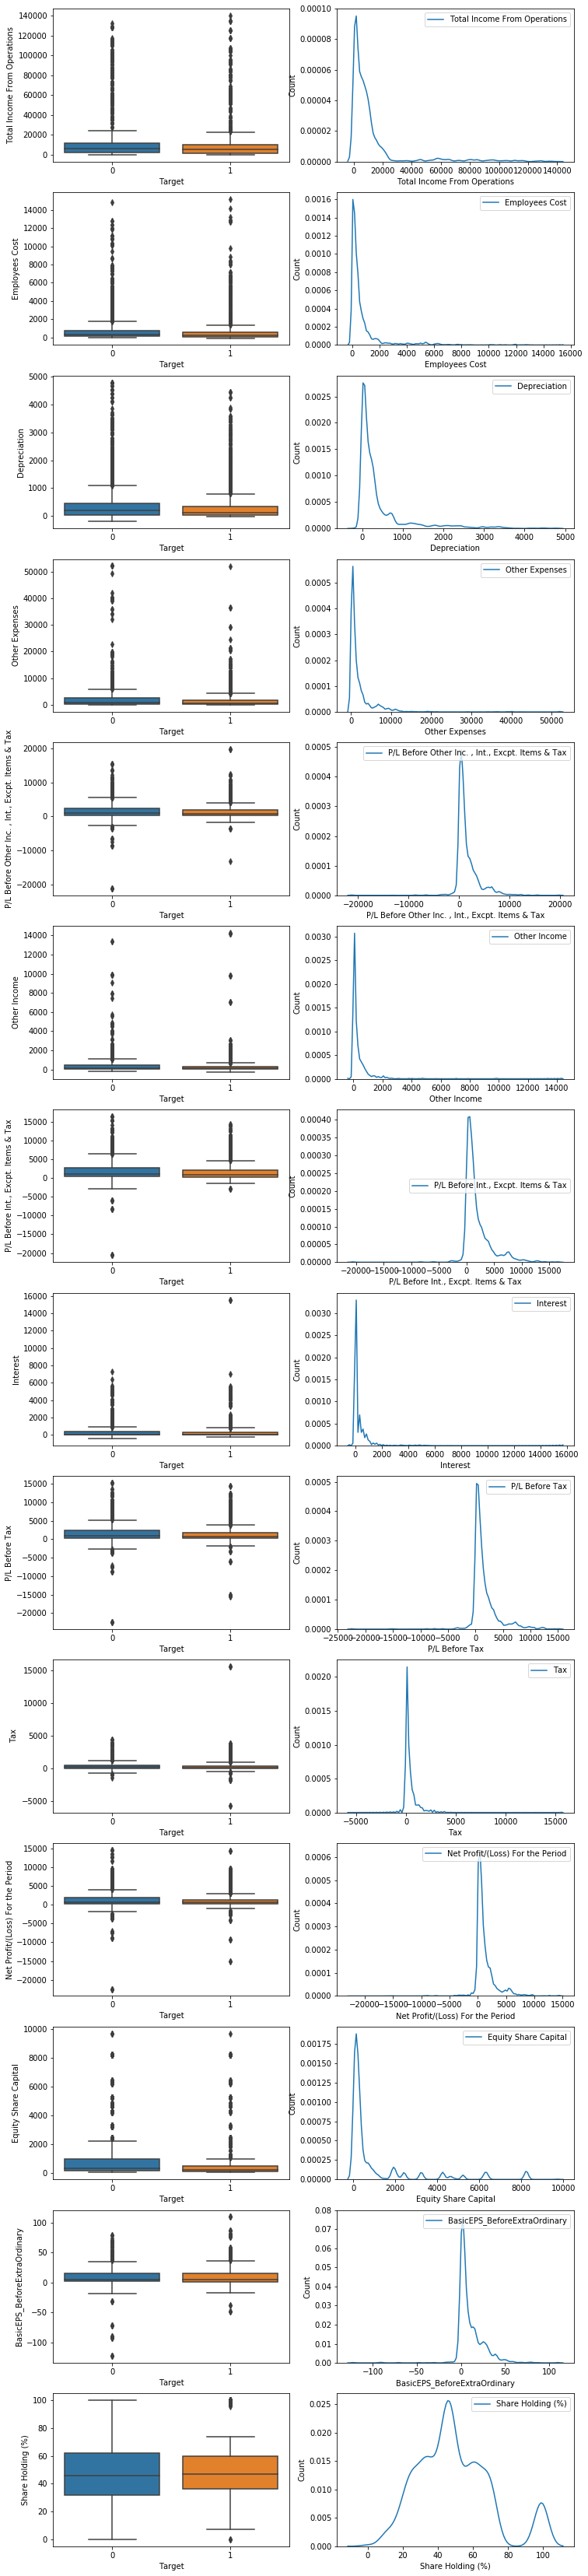

In [ ]:
## Analysis for entire Quaretly Data
bivariate_eda(train_data=train_dict,cols=quartelyFeatures,all=True)

### Bi-variate Analysis of Yearly data with Target column

(584, 42)


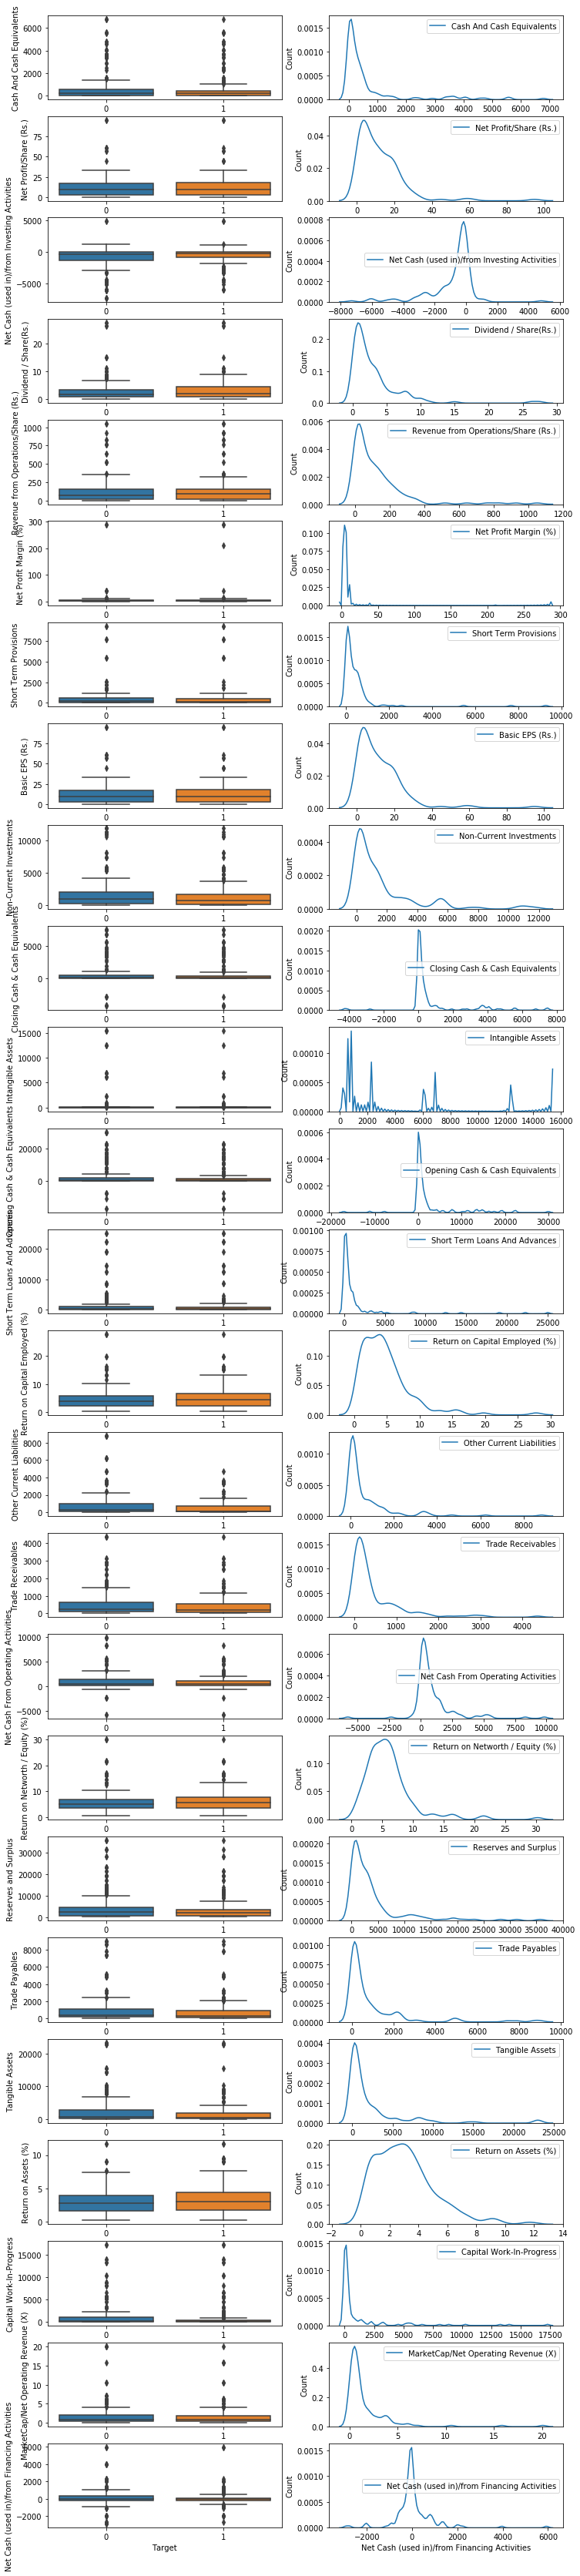

In [ ]:
# Analysis for STEP 0
bivariate_eda(train_data=train_dict[0],cols=yearlyFeatures)

(4951, 42)


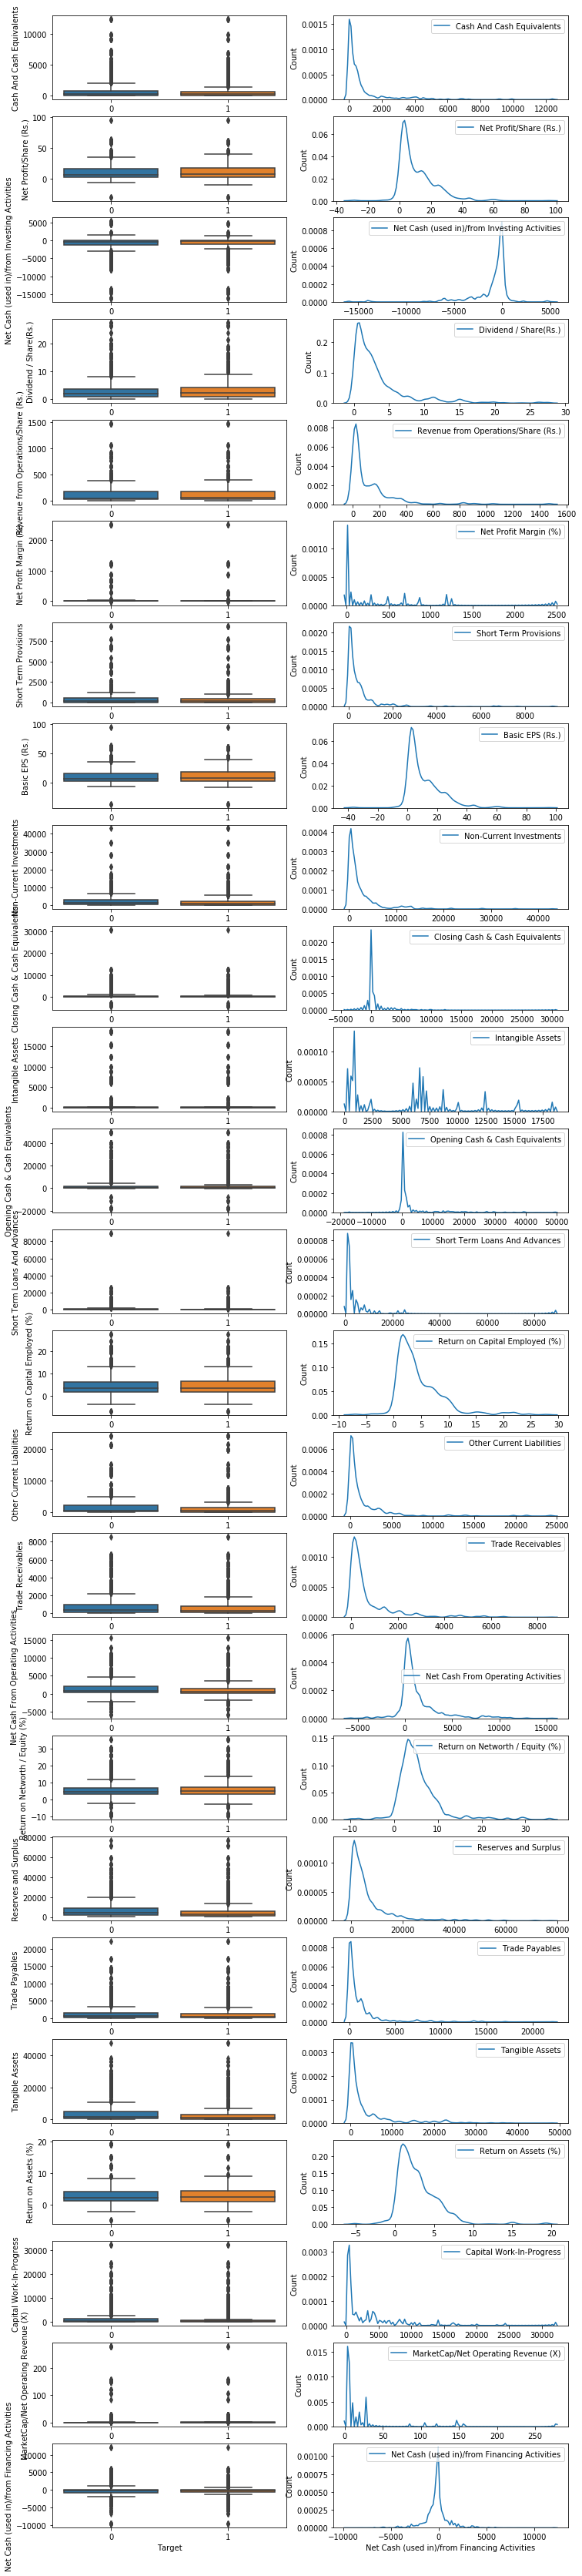

In [ ]:
# Analysis for entire Yearly data
bivariate_eda(train_data=train_dict,cols=yearlyFeatures,all=True)

Pair Plot of Quartely data italicized text

In [ ]:
quartelyFeatures.append('Target')

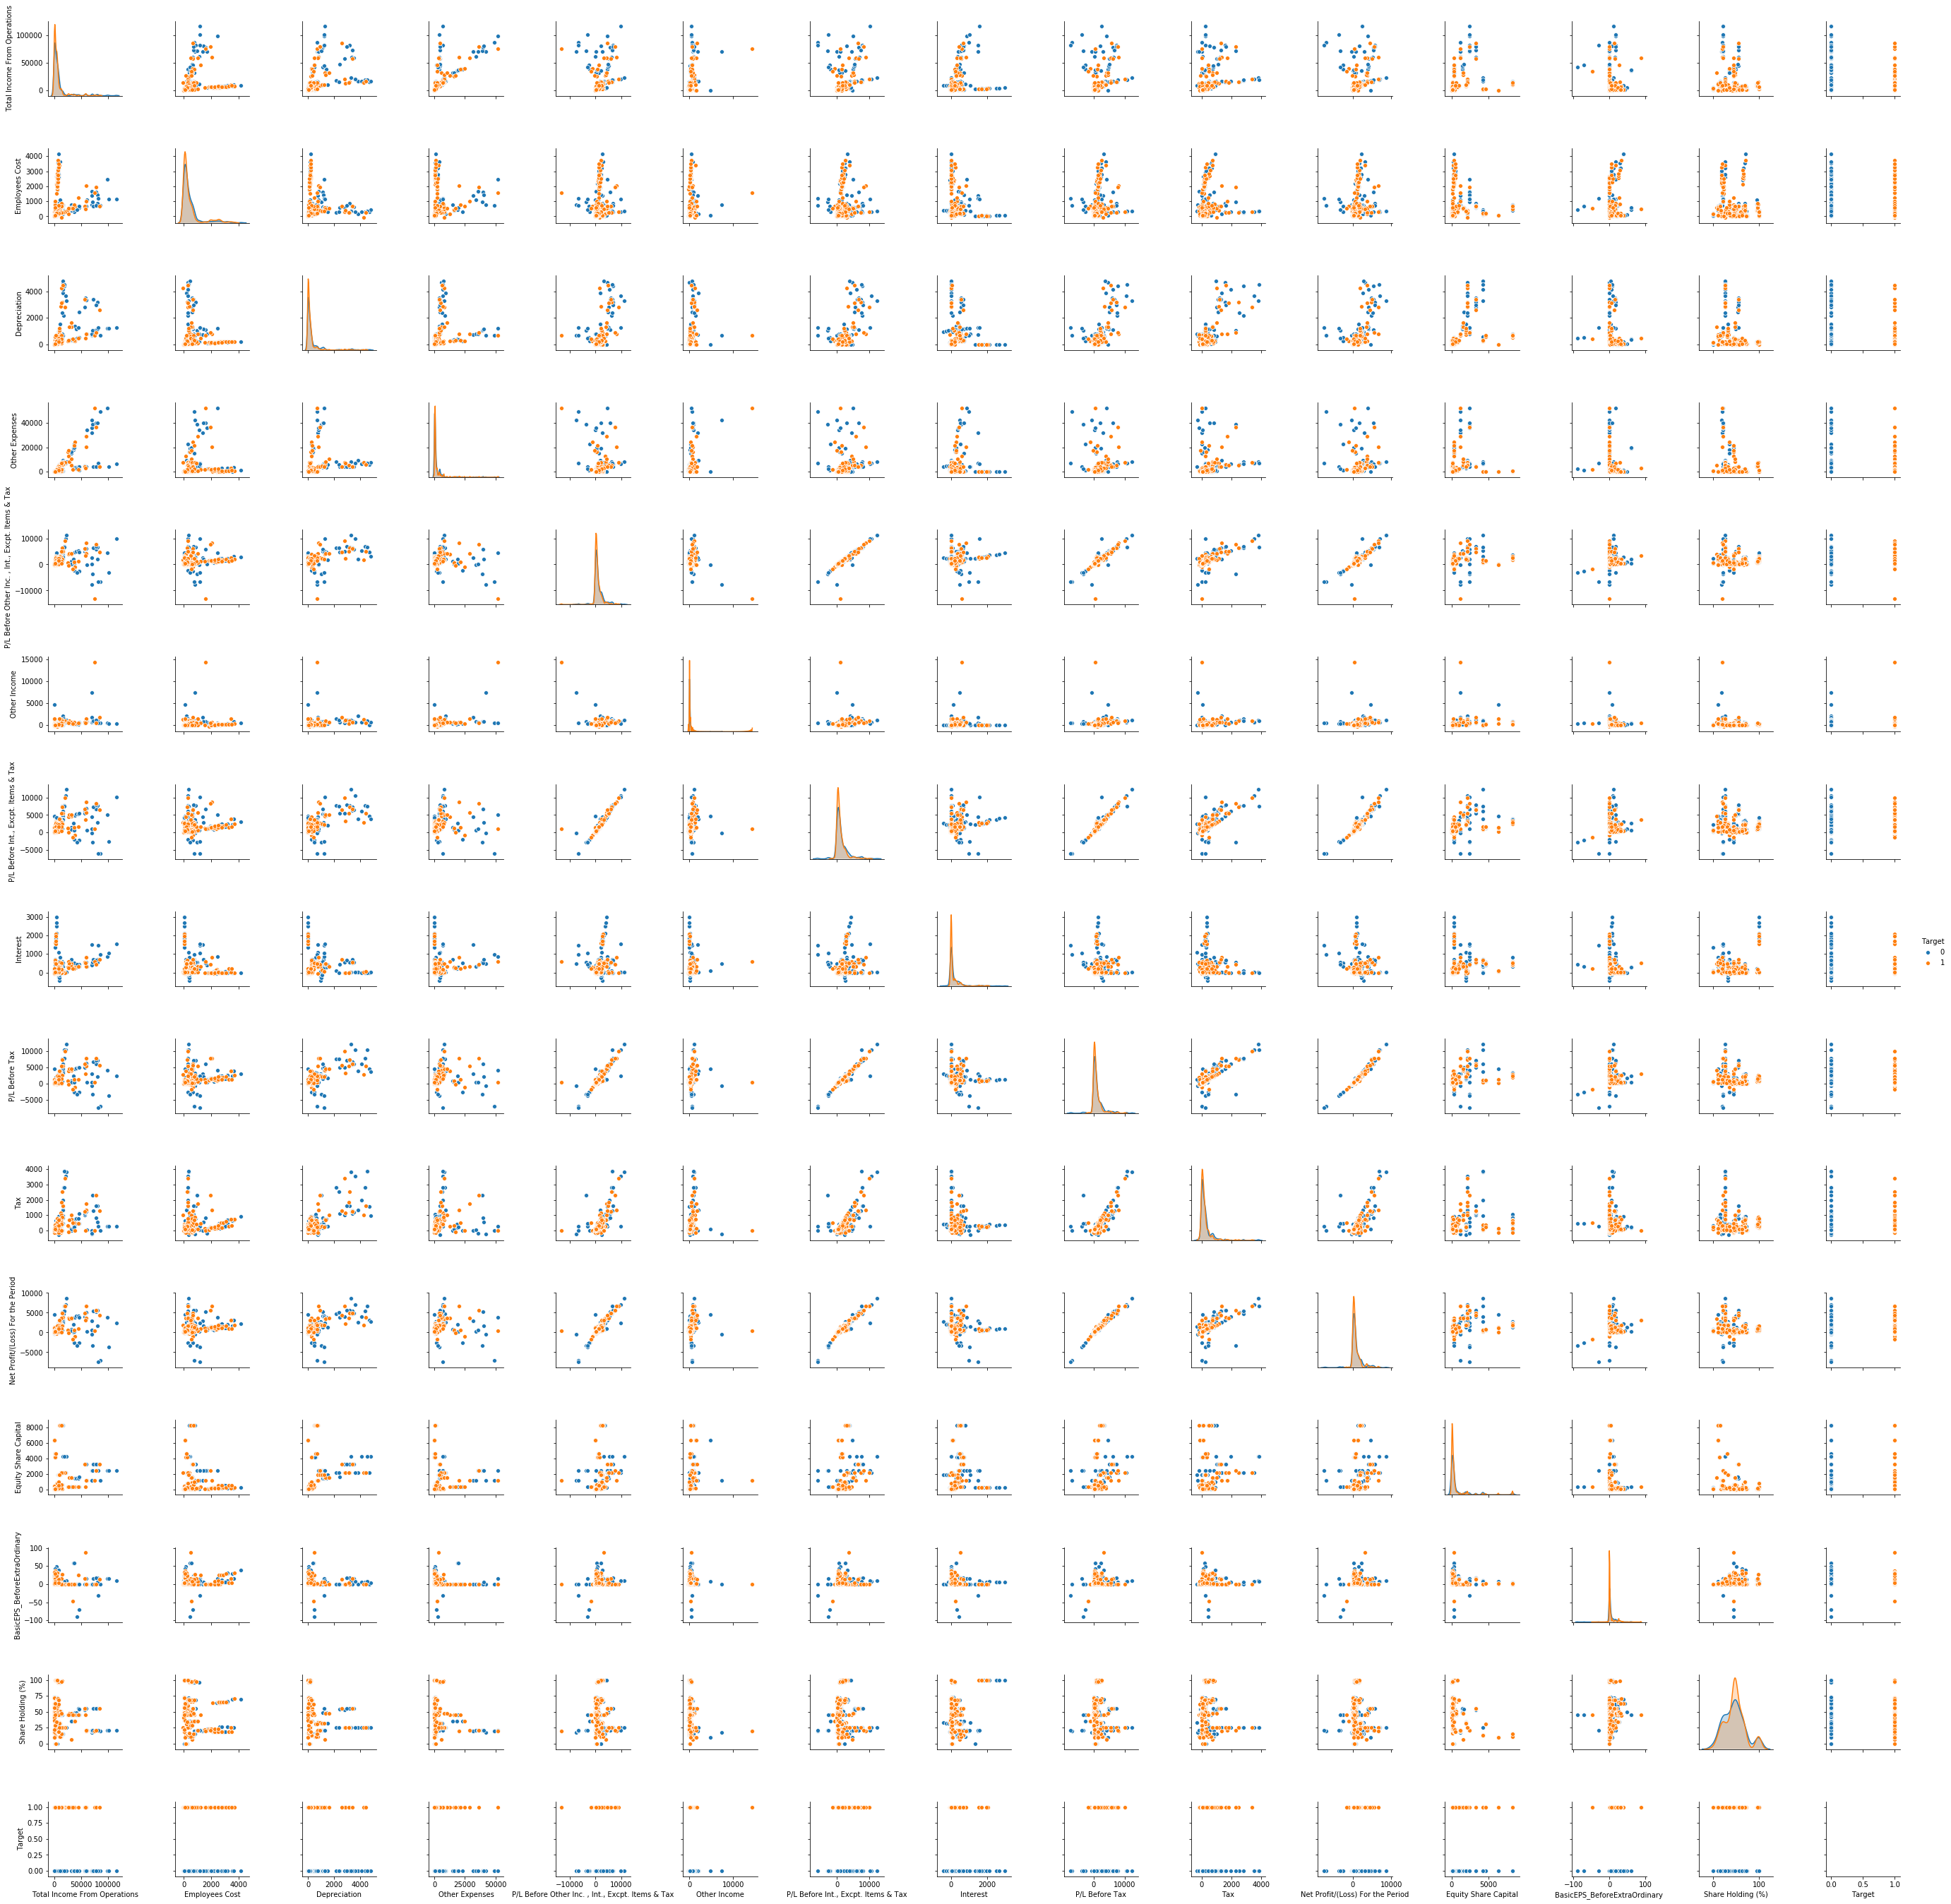

In [ ]:
sns.pairplot(train_dict[0][quartelyFeatures],diag_kind='kde',hue='Target')